In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
!unzip ecg-id-database-1.0.0.zip

Archive:  ecg-id-database-1.0.0.zip
 extracting: ecg-id-database-1.0.0/SHA256SUMS.txt  
 extracting: ecg-id-database-1.0.0/RECORDS  
 extracting: ecg-id-database-1.0.0/biometric.shtml  
 extracting: ecg-id-database-1.0.0/ANNOTATORS  
 extracting: ecg-id-database-1.0.0/README  
 extracting: ecg-id-database-1.0.0/Person_42/rec_3.hea  
 extracting: ecg-id-database-1.0.0/Person_42/rec_3.atr  
 extracting: ecg-id-database-1.0.0/Person_42/rec_2.dat  
 extracting: ecg-id-database-1.0.0/Person_42/rec_4.dat  
 extracting: ecg-id-database-1.0.0/Person_42/rec_2.hea  
 extracting: ecg-id-database-1.0.0/Person_42/rec_1.atr  
 extracting: ecg-id-database-1.0.0/Person_42/rec_4.atr  
 extracting: ecg-id-database-1.0.0/Person_42/rec_4.hea  
 extracting: ecg-id-database-1.0.0/Person_42/rec_2.atr  
 extracting: ecg-id-database-1.0.0/Person_42/rec_3.dat  
 extracting: ecg-id-database-1.0.0/Person_42/rec_1.hea  
 extracting: ecg-id-database-1.0.0/Person_42/rec_1.dat  
 extracting: ecg-id-database-1.0.0/Per

In [ ]:
general_directory = os.path.join("/content/ecg-id-database-1.0.0")
enteries = os.listdir(general_directory)

In [ ]:
fs = 500  # Sampling frequency indicated by the publisher of the database

# Initializing lists to store extracted features
subject, age, gender, RR, ecg_mean, ecg_std, ecg_var, ecg_median, ecg_samples = [], [], [], [], [], [], [], [], []

# Loop through each folder to extract the relevant information
for folder in enteries:
    if "Person_" in folder:
        info_targetPattern = os.path.join(general_directory, folder, '*.hea')
        info_files = glob.glob(info_targetPattern)

        for ecg_info in info_files:
            try:
                with open(ecg_info) as f:
                    subject_info = int(folder.replace("Person_", "", 1))

                    # Extracting demographic information
                    lines = [line.rstrip() for line in f]
                    age_info = int([int(s) for s in lines[4].split() if s.isdigit()][0])
                    condition = lines[5].find('female')
                    gender_info = 'female' if condition > 0 else 'male'

                    ecg_signal_file = ecg_info.replace(".hea", ".dat")
                    ecg_signal = np.fromfile(ecg_signal_file, dtype='int32')
                    ecg_signal = ecg_signal / np.max(np.abs(ecg_signal))  # Normalizing signal
                    ts = np.arange(0, len(ecg_signal) / fs, 1 / fs)

                    # RR intervals calculation
                    pks_RR = sp.signal.find_peaks(ecg_signal, height=np.mean(np.abs(ecg_signal) * 5), distance=500)[0]

                    RR_samples = np.diff(pks_RR)
                    RR_time = RR_samples * ts[1]

                    # Handling cases where not enough RR intervals are found
                    if len(pks_RR) <= 1:
                        subject.append(subject_info)
                        age.append(age_info)
                        gender.append(gender_info)
                        ecg_mean.append(np.nan)
                        ecg_std.append(np.nan)
                        ecg_var.append(np.nan)
                        ecg_median.append(np.nan)
                        RR.append(np.nan)
                        ecg_samples.append(np.nan)
                    else:
                        for index in range(len(pks_RR) - 1):
                            subject.append(subject_info)
                            age.append(age_info)
                            gender.append(gender_info)
                            ecg_mean.append(np.mean(ecg_signal[pks_RR[index]:pks_RR[index + 1]]))
                            ecg_std.append(np.std(ecg_signal[pks_RR[index]:pks_RR[index + 1]]))
                            ecg_var.append(np.var(ecg_signal[pks_RR[index]:pks_RR[index + 1]]))
                            ecg_median.append(np.median(ecg_signal[pks_RR[index]:pks_RR[index + 1]]))
                            RR.append(RR_time[index])
                            ecg_samples.append(ecg_signal[pks_RR[index]:pks_RR[index + 1]])
            except Exception as e:
                print(f"Error processing file {ecg_info}: {e}")

# Creating the DataFrame
df = pd.DataFrame({
    'Subject': subject,
    'Age': age,
    'Gender': gender,
    'RR_Interval': RR,
    'ECG_Mean': ecg_mean,
    'ECG_Std': ecg_std,
    'ECG_Var': ecg_var,
    'ECG_Median': ecg_median,
    'ECG_Samples': ecg_samples
})

# Convert columns to appropriate numeric types
df['RR_Interval'] = pd.to_numeric(df['RR_Interval'], errors='coerce')
df['ECG_Mean'] = pd.to_numeric(df['ECG_Mean'], errors='coerce')
df['ECG_Std'] = pd.to_numeric(df['ECG_Std'], errors='coerce')
df['ECG_Var'] = pd.to_numeric(df['ECG_Var'], errors='coerce')
df['ECG_Median'] = pd.to_numeric(df['ECG_Median'], errors='coerce')

df.dropna(inplace=True)
df = df.sort_values(by=['Subject'])
df.reset_index(inplace=True, drop=True)
df.head()

Subject  Age Gender  RR_Interval  ECG_Mean   ECG_Std   ECG_Var  ECG_Median  \
0        1   25   male        2.234  0.002896  0.165863  0.027510   -0.049080   
1        1   25   male        1.614  0.005171  0.162207  0.026311   -0.046665   
2        1   25   male        2.398  0.005710  0.157191  0.024709   -0.046668   
3        1   25   male        1.648  0.002451  0.166950  0.027872   -0.053336   
4        1   25   male        2.416  0.004779  0.170291  0.028999   -0.059999   

                                         ECG_Samples  
0  [1.0, 0.9631898584210202, 0.8711664234967823, ...  
1  [0.8266653442584596, 0.8133315023065851, 0.753...  
2  [0.9466670735614996, 0.9400015258556236, 0.886...  
3  [0.8666660563244173, 0.8333312988591686, 0.766...  
4  [0.986666361495542, 0.9799981689732518, 0.9199...

In [ ]:
signal_lenghts = [i.__len__() for i in df['ECG_Samples'].values[0:]]
print(max(signal_lenghts)), print(np.mean(signal_lenghts)), print(min(signal_lenghts))

6861
885.6027542372881
500


(None, None, None)

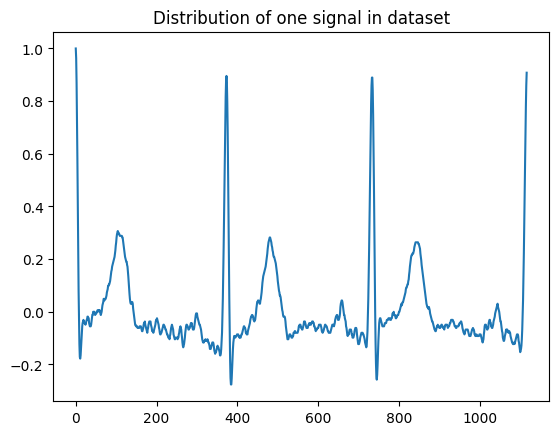

In [ ]:
plt.plot(df['ECG_Samples'][0])
plt.title('Distribution of one signal in dataset');

In [ ]:
# Show a preview of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2832 entries, 0 to 2831
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Subject      2832 non-null   int64  
 1   Age          2832 non-null   int64  
 2   Gender       2832 non-null   object 
 3   RR_Interval  2832 non-null   float64
 4   ECG_Mean     2832 non-null   float64
 5   ECG_Std      2832 non-null   float64
 6   ECG_Var      2832 non-null   float64
 7   ECG_Median   2832 non-null   float64
 8   ECG_Samples  2832 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 199.2+ KB


In [ ]:
# Step 1: Get unique subject IDs in the dataset
unique_subjects = sorted(df['Subject'].unique())

# Step 2: Create a mapping from old subject IDs to new consecutive values
subject_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_subjects, start=1)}

# Step 3: Apply the mapping to the 'Subject' column
df['Subject'] = df['Subject'].map(subject_mapping)

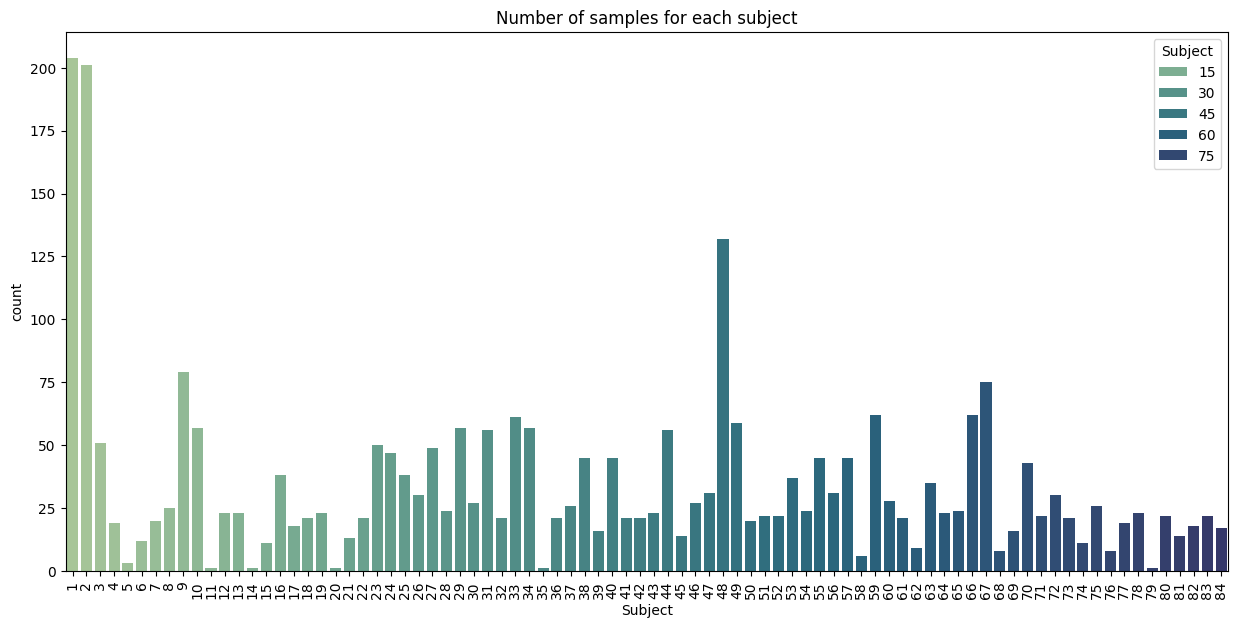

In [ ]:
plt.figure(figsize=(15, 7))
sns.countplot(df, x='Subject', hue='Subject', palette=sns.color_palette("crest", as_cmap=True))
plt.title("Number of samples for each subject");
plt.xticks(rotation=90);

In [ ]:
# find signals lenght and get the longest lenght of them,
# all other signals should be padded into the max lenght or mean lenght in order
# to have integrated length
signal_lenghts = [i.__len__() for i in df['ECG_Samples'].values[0:]]
max_length, mean_lenght = max(signal_lenghts), round(np.mean(signal_lenghts))  # Maximum & Mean length of ECG samples
print(max_length), print(mean_lenght)

6861
886


(None, None)

In [ ]:
# Define a fixed signal length (based on the max length in your dataset)
max_signal_length = max_length  # Example value, adjust accordingly

# Function to pad or truncate ECG signals
def pad_truncate_signal_max(signal, target_length=max_length):
    if len(signal) > target_length:
        return signal[:target_length]
    elif len(signal) < target_length:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')
    else:
        return signal

# Function to pad or truncate ECG signals with mean padding
def pad_truncate_signal_mean(signal, target_length=mean_lenght):
    signal_mean = np.mean(signal)  # Calculate the mean of the signal

    if len(signal) > target_length:
        # Truncate the signal if it's longer than the target length
        return signal[:target_length]
    elif len(signal) < target_length:
        # Pad the signal with its mean value if it's shorter than the target length
        padding = (0, target_length - len(signal))
        return np.pad(signal, padding, 'constant', constant_values=(signal_mean,))
    else:
        return signal  # Return the original signal if it's the right length

# Function to apply moving average smoothing
def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# Apply the function to each ECG sample in the DataFrame
df['ECG_Samples'] = df['ECG_Samples'].apply(lambda x: pad_truncate_signal_mean(x))

# Apply the smoothing function to each ECG sample in the DataFrame
df['Smoothed_ECG_Samples'] = df['ECG_Samples'].apply(lambda x: moving_average(np.array(x), window_size=15))

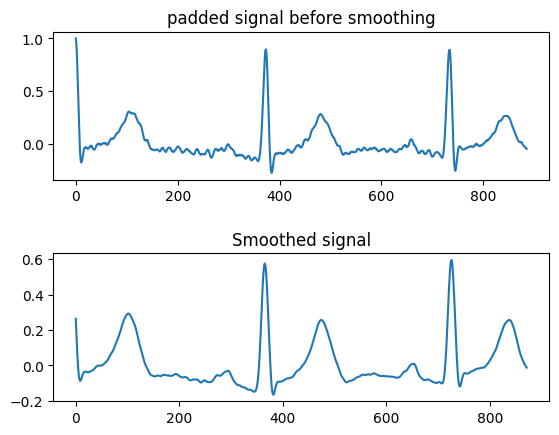

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(df['ECG_Samples'][0])
plt.title('padded signal before smoothing')
plt.subplot(2, 1, 2)
plt.plot(df['Smoothed_ECG_Samples'][0])
plt.title('Smoothed signal')
plt.subplots_adjust(hspace=0.5)
plt.show()

Huber Loss – Loss function to use in Regression when dealing with Outliers

In [ ]:
len(df['Smoothed_ECG_Samples'][0]), len(df['ECG_Samples'][0])

(872, 886)

In [ ]:
# Define the dimensions
input_dim = len(df['Smoothed_ECG_Samples'][0])  # The original signal length, e.g., 6861
encoding_dim = 50  # Reduced dimensionality, e.g., 50

# Ensure that your 'Smoothed_ECG_Samples' is a NumPy array with correct shape (n_samples, input_dim)
# Convert 'Smoothed_ECG_Samples' from the DataFrame to a NumPy array
ecg_samples_np = np.array(df['Smoothed_ECG_Samples'].tolist())

# Check the shape of the data to confirm it's (n_samples, `max_lenght or mean lenght`)
print(ecg_samples_np.shape)  # Should print something like (2832, `max_lenght or mean lenght`)

# Define the encoder model
input_signal = Input(shape=(input_dim,))
encoded = Dense(128, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform(), kernel_regularizer=l2(0.001))(input_signal)
encoded = Dropout(0.2)(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(256, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform(), kernel_regularizer=l2(0.001))(encoded)
encoded = Dropout(0.2)(encoded)
encoded = BatchNormalization()(encoded)

encoded = Dense(encoding_dim, activation='tanh')(encoded)

# Define the decoder model
decoded = Dense(128, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform(), kernel_regularizer=l2(0.001))(encoded)
decoded = Dropout(0.2)(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(256, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform(), kernel_regularizer=l2(0.001))(decoded)
decoded = Dropout(0.2)(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(input_dim, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform())(decoded)

# Define the full autoencoder model
autoencoder = Model(input_signal, decoded)

# Decrease the learning rate
optimizer = Adam(learning_rate=0.001)

early_stopping = EarlyStopping(monitor='loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)

# Compile the autoencoder
autoencoder.compile(optimizer=optimizer, loss='huber')

# Train the autoencoder
autoencoder.fit(ecg_samples_np, ecg_samples_np, epochs=100, batch_size=64, shuffle=True, callbacks=[early_stopping, reduce_lr])

# Extract the encoder model to get the compressed representations
encoder = Model(input_signal, encoded)
decoder = Model(encoded, decoded)

# Now you can encode and decode the data
compressed_signals = encoder.predict(ecg_samples_np)  # Encode the data
reconstructed_signals = decoder.predict(compressed_signals)  # Decode the data back to original

(2832, 872)
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5930 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1815 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0605 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0249 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0139 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0096 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0075 - learning_rate: 0.0010
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0063 - learning_rate: 0.0010
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0054 - learning_rate: 0.0010
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0051 - learnin

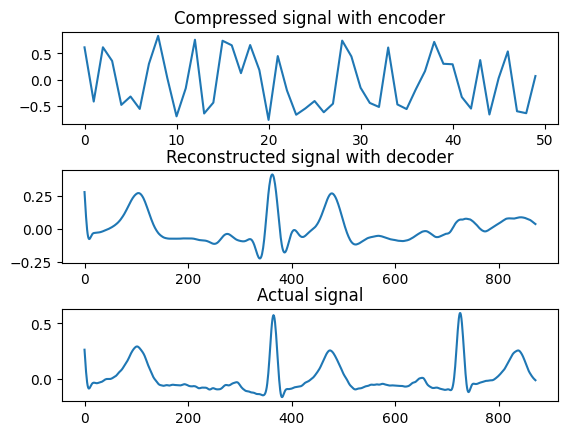

In [ ]:
plt.subplot(3, 1, 1)
plt.plot(compressed_signals[0])
plt.title('Compressed signal with encoder')
plt.subplot(3, 1, 2)
plt.plot(reconstructed_signals[0])
plt.title('Reconstructed signal with decoder')
plt.subplot(3, 1, 3)
plt.plot(ecg_samples_np[0])
plt.title('Actual signal')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# create a list contain all numpy arrays of decomposited signals and add it to original dataframe
compressed_list = [np.array(i) for i in compressed_signals]
compressed_signals_df = pd.DataFrame({'compressed_signals': compressed_list})
concat_df = pd.merge(df, compressed_signals_df, left_index=True, right_index=True)
concat_df.head()

Subject  Age Gender  RR_Interval  ECG_Mean   ECG_Std   ECG_Var  ECG_Median  \
0        1   25   male        2.234  0.002896  0.165863  0.027510   -0.049080   
1        1   25   male        1.614  0.005171  0.162207  0.026311   -0.046665   
2        1   25   male        2.398  0.005710  0.157191  0.024709   -0.046668   
3        1   25   male        1.648  0.002451  0.166950  0.027872   -0.053336   
4        1   25   male        2.416  0.004779  0.170291  0.028999   -0.059999   

                                         ECG_Samples  \
0  [1.0, 0.9631898584210202, 0.8711664234967823, ...   
1  [0.8266653442584596, 0.8133315023065851, 0.753...   
2  [0.9466670735614996, 0.9400015258556236, 0.886...   
3  [0.8666660563244173, 0.8333312988591686, 0.766...   
4  [0.986666361495542, 0.9799981689732518, 0.9199...   

                                Smoothed_ECG_Samples  \
0  [0.2633957212459958, 0.19141234928568962, 0.12...   
1  [0.20222094050349845, 0.13688776314651774, 0.0...   
2  [0.2653333265517528, 0.19244439019180012, 0.12...   
3  [0.23199938965775052, 0.16844395617064487, 0.1...   
4  [0.29911039226357283, 0.22799935574984773, 0.1...   

                                  compressed_signals  
0  [0.61469835, -0.41005424, 0.6160984, 0.3577404...  
1  [0.6073337, -0.07966085, 0.073114075, -0.57461...  
2  [0.51680195, -0.03539619, 0.2033949, -0.450268...  
3  [0.6154747, 0.043679398, 0.13227785, -0.496362...  
4  [0.46681818, 0.087902434, 0.42101315, -0.42135...

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import keras
from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

Epoch 1/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - d_loss: 0.5329 - feature_matching_loss: 1.4087 - g_loss: 2.3696
Epoch 2/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - d_loss: 0.5787 - feature_matching_loss: 2.0630 - g_loss: 2.9434
Epoch 3/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - d_loss: 0.6760 - feature_matching_loss: 1.8333 - g_loss: 2.8925
Epoch 4/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - d_loss: 0.6288 - feature_matching_loss: 1.8958 - g_loss: 3.0967
Epoch 5/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - d_loss: 0.5179 - feature_matching_loss: 4.3159 - g_loss: 5.7443
Epoch 6/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - d_loss: 0.4116 - feature_matching_loss: 7.3274 - g_loss: 9.1277
Epoch 7/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - d_loss: 0.4483 - feature_matching_loss: 8.0088 - g_loss: 9.8696
Epoch 8/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - d_loss: 0.2769 - feature_matching_loss: 13.8973 - g_loss: 16.2096
Epoch 9/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10m

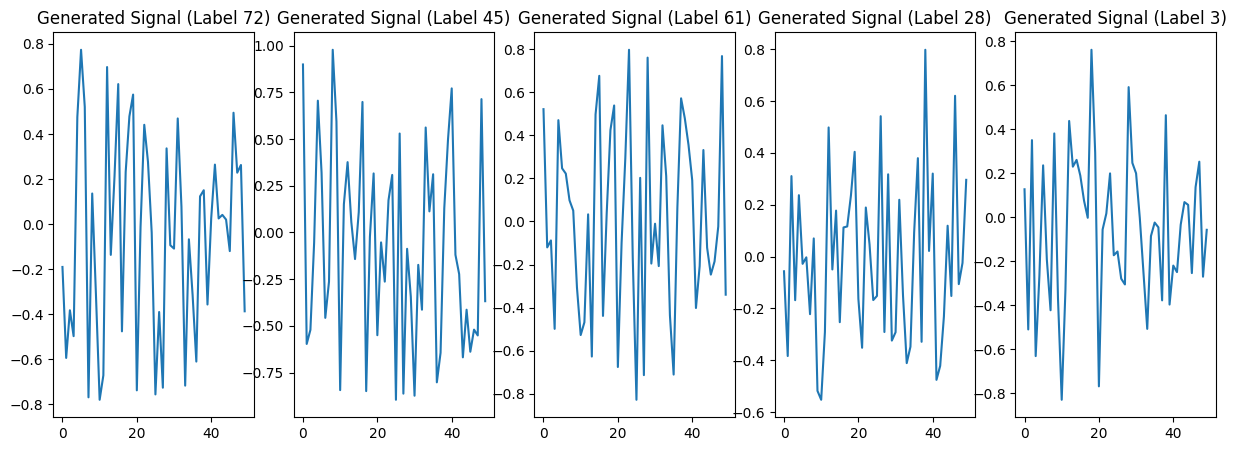

Epoch 51/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.0778 - feature_matching_loss: 63.4690 - g_loss: 67.5793
Epoch 52/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - d_loss: 0.0882 - feature_matching_loss: 61.3787 - g_loss: 65.2684
Epoch 53/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - d_loss: 0.0822 - feature_matching_loss: 61.7321 - g_loss: 65.7336
Epoch 54/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - d_loss: 0.0843 - feature_matching_loss: 61.6848 - g_loss: 65.5685
Epoch 55/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - d_loss: 0.0806 - feature_matching_loss: 61.7508 - g_loss: 65.5730
Epoch 56/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.0783 - feature_matching_loss: 64.4331 - g_loss: 68.3436
Epoch 57/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.0756 - feature_matching_loss: 63.3910 - g_loss: 67.2600
Epoch 58/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - d_loss: 0.0719 - feature_matching_loss: 66.9654 - g_loss: 70.9787
Epoch 59/1000
45/45 ━━━━

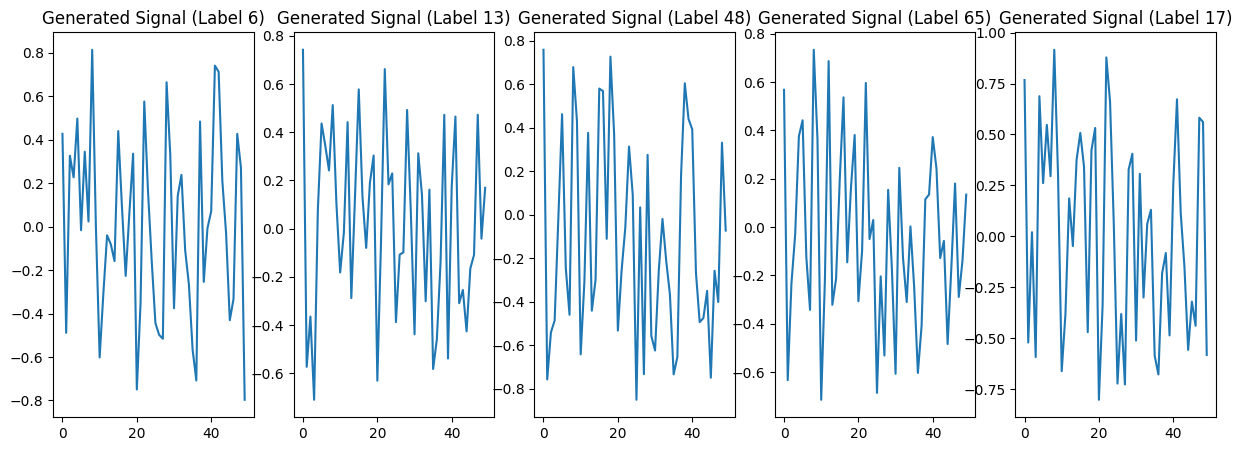

Epoch 101/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - d_loss: 0.0777 - feature_matching_loss: 153.8585 - g_loss: 158.8159
Epoch 102/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.0851 - feature_matching_loss: 151.2215 - g_loss: 156.0954
Epoch 103/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.0858 - feature_matching_loss: 149.3435 - g_loss: 154.3455
Epoch 104/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.0903 - feature_matching_loss: 145.8219 - g_loss: 150.3414
Epoch 105/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - d_loss: 0.0875 - feature_matching_loss: 146.7352 - g_loss: 151.8724
Epoch 106/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - d_loss: 0.0894 - feature_matching_loss: 146.0686 - g_loss: 150.8538
Epoch 107/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - d_loss: 0.0842 - feature_matching_loss: 145.3998 - g_loss: 150.2094
Epoch 108/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.0955 - feature_matching_loss: 146.8072 - g_loss: 151.5170


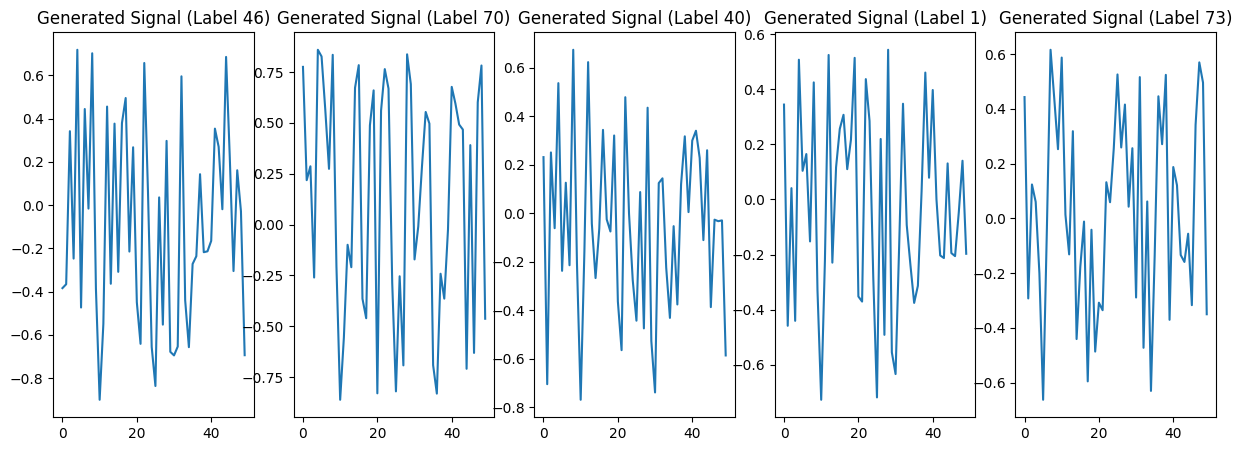

Epoch 151/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.1103 - feature_matching_loss: 175.7747 - g_loss: 180.5046
Epoch 152/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.1151 - feature_matching_loss: 164.5115 - g_loss: 168.9602
Epoch 153/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.1153 - feature_matching_loss: 178.8504 - g_loss: 183.6347
Epoch 154/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1178 - feature_matching_loss: 173.7306 - g_loss: 178.3313
Epoch 155/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1186 - feature_matching_loss: 166.3254 - g_loss: 170.8430
Epoch 156/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1113 - feature_matching_loss: 176.7935 - g_loss: 181.4809
Epoch 157/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1073 - feature_matching_loss: 162.3290 - g_loss: 166.7572
Epoch 158/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1124 - feature_matching_loss: 177.8343 - g_loss: 182.3828


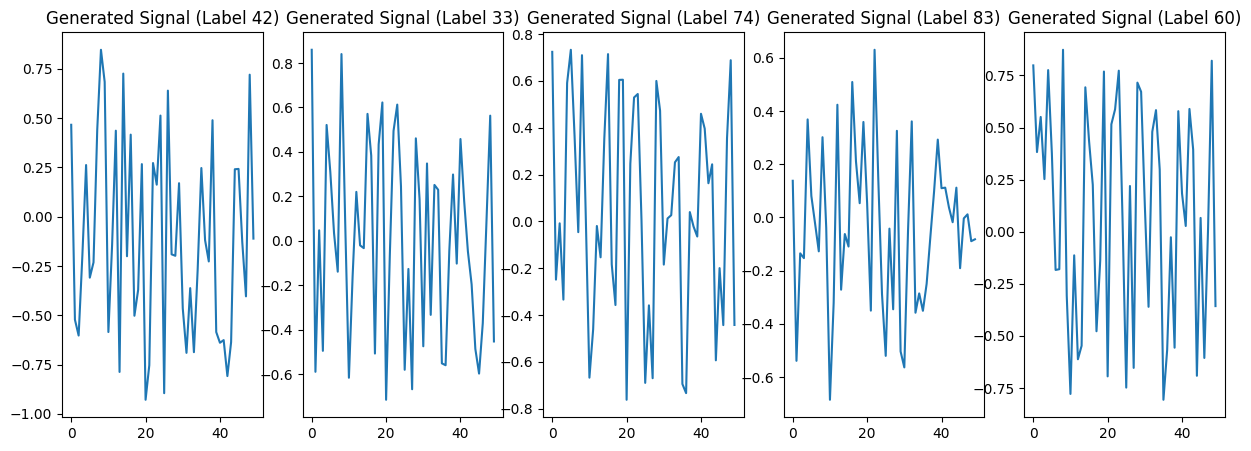

Epoch 201/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - d_loss: 0.1891 - feature_matching_loss: 166.7997 - g_loss: 170.6098
Epoch 202/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.1670 - feature_matching_loss: 178.1257 - g_loss: 181.9317
Epoch 203/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.1665 - feature_matching_loss: 166.4275 - g_loss: 170.2197
Epoch 204/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1637 - feature_matching_loss: 162.9703 - g_loss: 166.7803
Epoch 205/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.1606 - feature_matching_loss: 163.6357 - g_loss: 167.3358
Epoch 206/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1639 - feature_matching_loss: 163.8259 - g_loss: 167.5438
Epoch 207/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1653 - feature_matching_loss: 169.9080 - g_loss: 173.6890
Epoch 208/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.1701 - feature_matching_loss: 183.6166 - g_loss: 187.4287


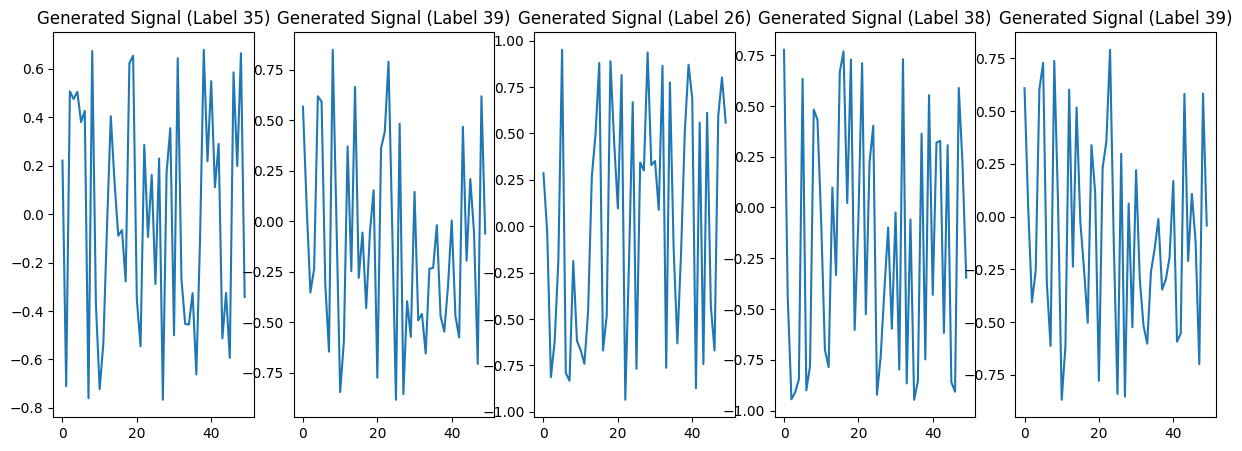

Epoch 251/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.1880 - feature_matching_loss: 179.7824 - g_loss: 183.2695
Epoch 252/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.1875 - feature_matching_loss: 167.1721 - g_loss: 170.3747
Epoch 253/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.1738 - feature_matching_loss: 165.4575 - g_loss: 168.6540
Epoch 254/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - d_loss: 0.1882 - feature_matching_loss: 190.2560 - g_loss: 193.7017
Epoch 255/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2117 - feature_matching_loss: 155.6752 - g_loss: 159.0690
Epoch 256/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.2034 - feature_matching_loss: 194.1855 - g_loss: 197.5169
Epoch 257/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.1924 - feature_matching_loss: 175.9969 - g_loss: 179.3832
Epoch 258/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.1938 - feature_matching_loss: 176.2387 - g_loss: 179.4765


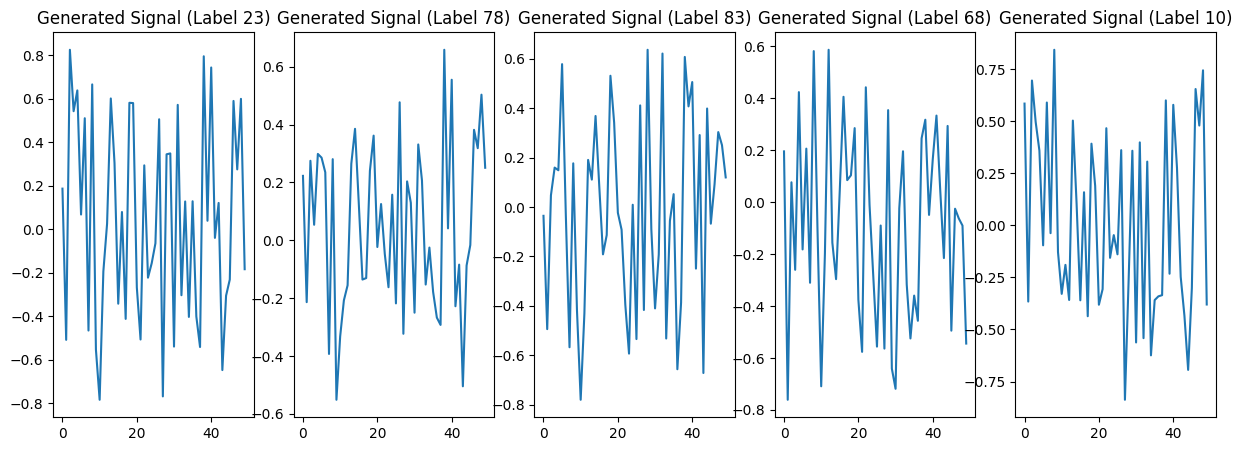

Epoch 301/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.2042 - feature_matching_loss: 152.4420 - g_loss: 155.5966
Epoch 302/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2144 - feature_matching_loss: 157.7685 - g_loss: 160.9656
Epoch 303/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.2307 - feature_matching_loss: 168.8992 - g_loss: 171.8528
Epoch 304/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2228 - feature_matching_loss: 135.9918 - g_loss: 138.9168
Epoch 305/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.2171 - feature_matching_loss: 161.2182 - g_loss: 164.1770
Epoch 306/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2060 - feature_matching_loss: 148.1487 - g_loss: 151.1438
Epoch 307/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2053 - feature_matching_loss: 153.3940 - g_loss: 156.4377
Epoch 308/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.1784 - feature_matching_loss: 153.3048 - g_loss: 156.2250


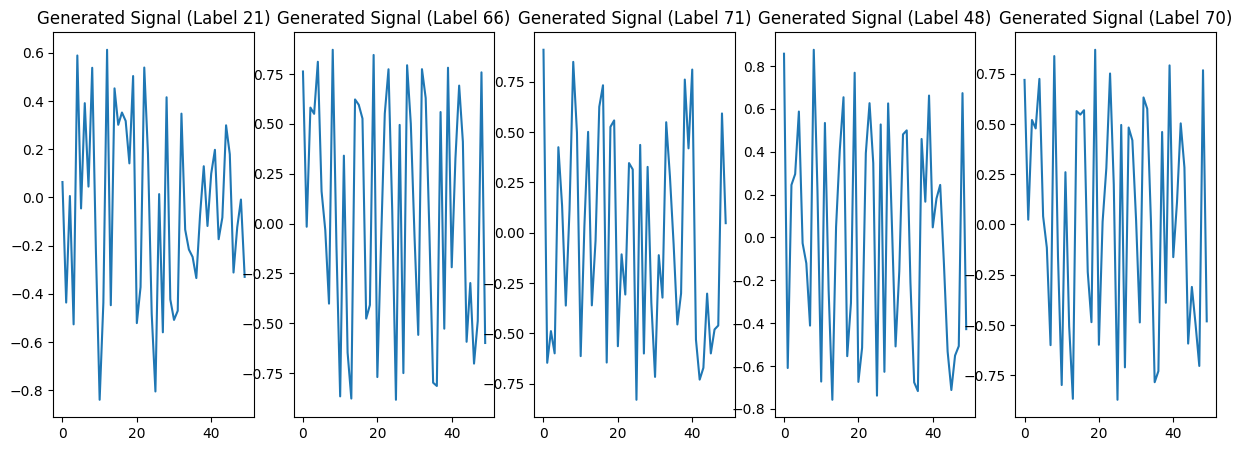

Epoch 351/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2141 - feature_matching_loss: 155.0304 - g_loss: 157.9173
Epoch 352/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.2419 - feature_matching_loss: 199.8728 - g_loss: 202.7578
Epoch 353/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - d_loss: 0.2272 - feature_matching_loss: 164.4869 - g_loss: 167.4560
Epoch 354/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2151 - feature_matching_loss: 188.8415 - g_loss: 191.8481
Epoch 355/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.2199 - feature_matching_loss: 177.9988 - g_loss: 180.8598
Epoch 356/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2360 - feature_matching_loss: 156.6157 - g_loss: 159.5182
Epoch 357/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.2191 - feature_matching_loss: 181.7705 - g_loss: 184.5268
Epoch 358/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2329 - feature_matching_loss: 166.4616 - g_loss: 169.2780


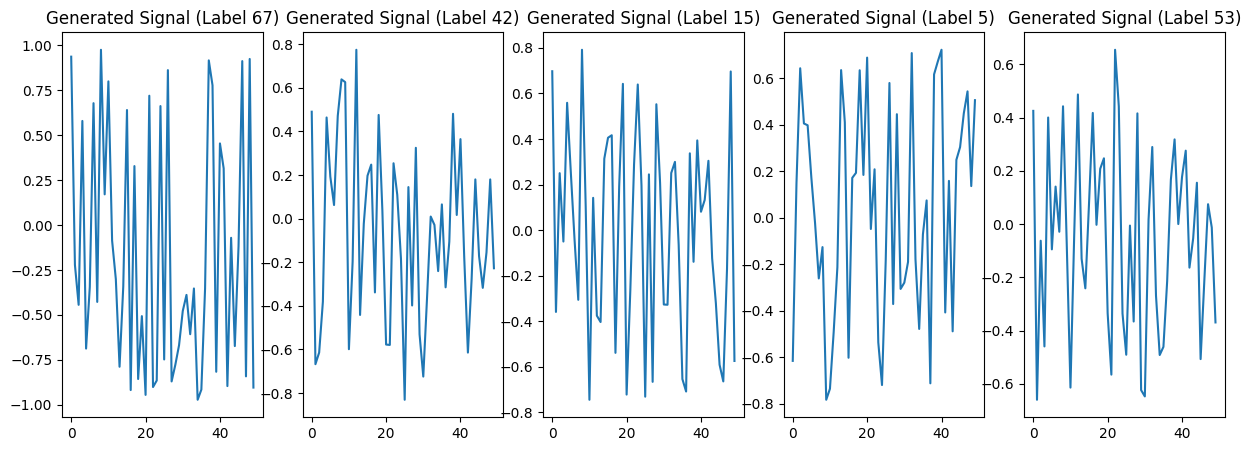

Epoch 401/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - d_loss: 0.2137 - feature_matching_loss: 175.0882 - g_loss: 177.8502
Epoch 402/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2484 - feature_matching_loss: 167.0734 - g_loss: 170.2344
Epoch 403/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - d_loss: 0.2406 - feature_matching_loss: 172.0253 - g_loss: 174.9680
Epoch 404/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2105 - feature_matching_loss: 161.9612 - g_loss: 164.7256
Epoch 405/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - d_loss: 0.2257 - feature_matching_loss: 175.5293 - g_loss: 178.3755
Epoch 406/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - d_loss: 0.2250 - feature_matching_loss: 165.7743 - g_loss: 168.4257
Epoch 407/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2552 - feature_matching_loss: 167.5874 - g_loss: 170.4860
Epoch 408/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2307 - feature_matching_loss: 152.9917 - g_loss: 155.8920


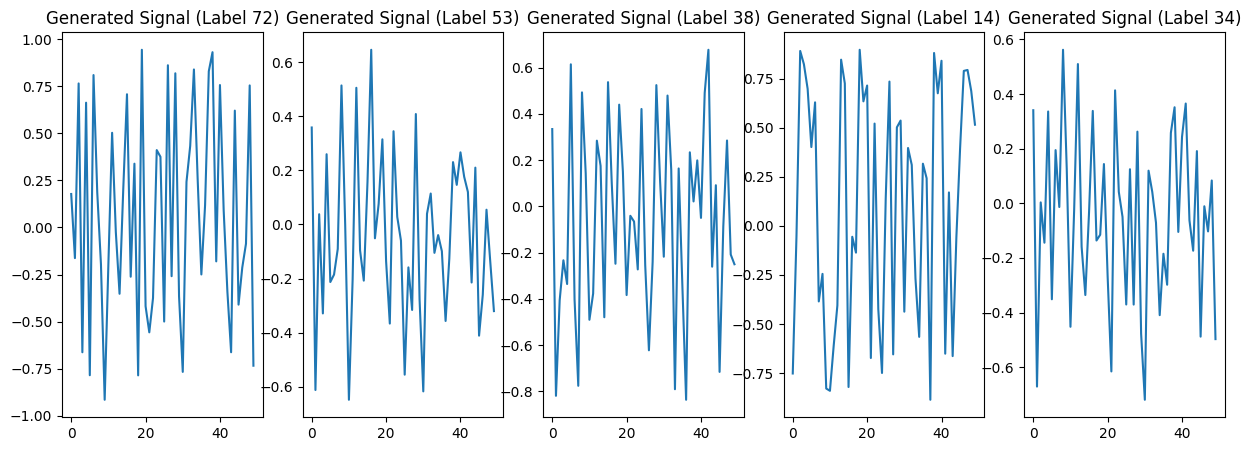

Epoch 451/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2347 - feature_matching_loss: 149.9673 - g_loss: 152.5170
Epoch 452/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - d_loss: 0.2257 - feature_matching_loss: 142.8268 - g_loss: 145.5471
Epoch 453/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - d_loss: 0.2240 - feature_matching_loss: 146.5278 - g_loss: 149.1299
Epoch 454/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2195 - feature_matching_loss: 151.8235 - g_loss: 154.5072
Epoch 455/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2401 - feature_matching_loss: 148.7227 - g_loss: 151.4959
Epoch 456/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - d_loss: 0.2196 - feature_matching_loss: 145.7163 - g_loss: 148.3344
Epoch 457/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2166 - feature_matching_loss: 154.6842 - g_loss: 157.3791
Epoch 458/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - d_loss: 0.2320 - feature_matching_loss: 141.2301 - g_loss: 143.9769


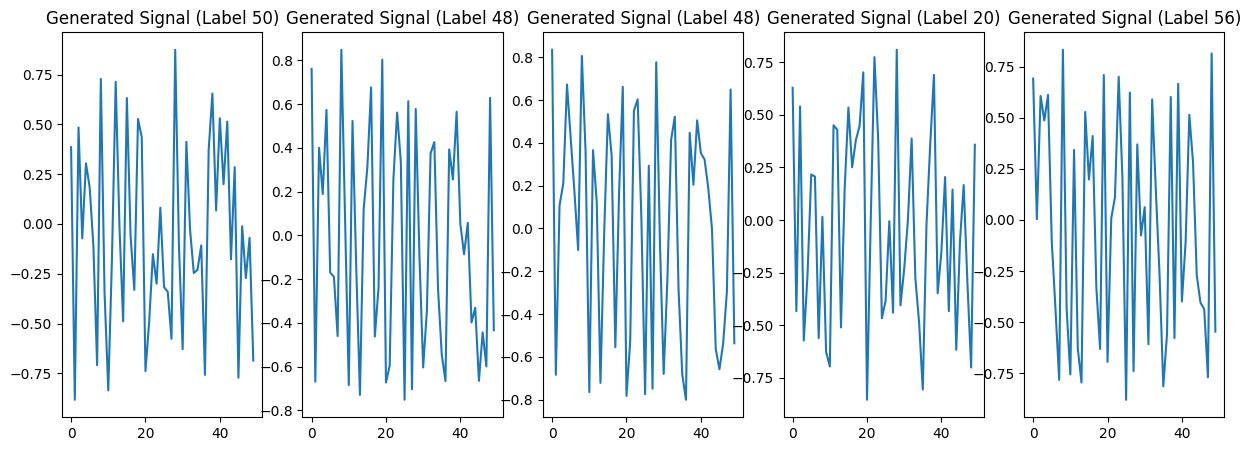

Epoch 501/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2598 - feature_matching_loss: 143.9634 - g_loss: 146.7109
Epoch 502/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.2335 - feature_matching_loss: 131.2806 - g_loss: 133.9568
Epoch 503/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2309 - feature_matching_loss: 154.4893 - g_loss: 157.1555
Epoch 504/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2219 - feature_matching_loss: 119.0282 - g_loss: 121.6236
Epoch 505/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2409 - feature_matching_loss: 152.1232 - g_loss: 154.8666
Epoch 506/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2478 - feature_matching_loss: 127.4024 - g_loss: 130.1409
Epoch 507/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2199 - feature_matching_loss: 154.8819 - g_loss: 157.4484
Epoch 508/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2484 - feature_matching_loss: 126.4755 - g_loss: 129.1429


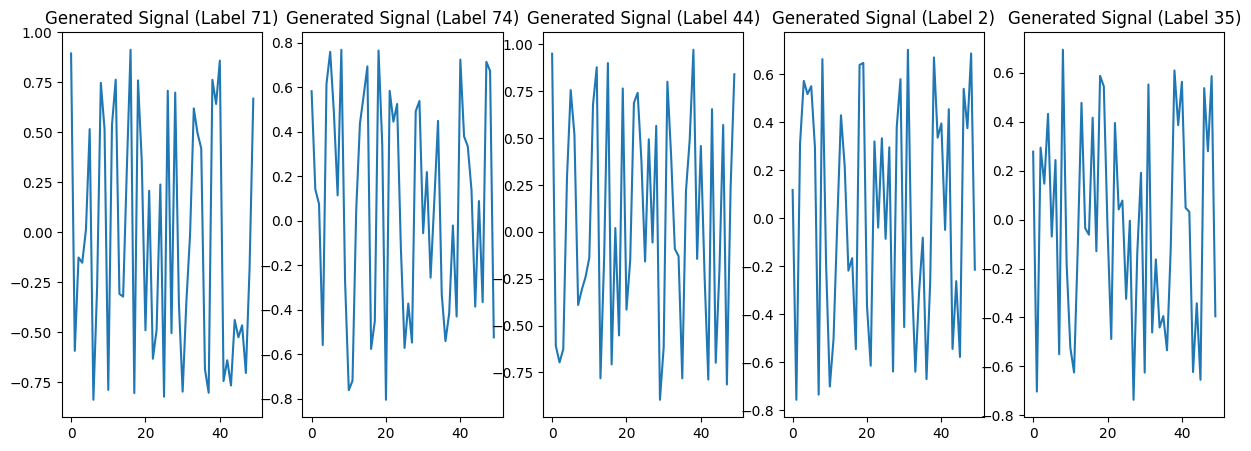

Epoch 551/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2350 - feature_matching_loss: 129.3153 - g_loss: 131.8920
Epoch 552/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - d_loss: 0.2231 - feature_matching_loss: 127.9761 - g_loss: 130.6135
Epoch 553/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2494 - feature_matching_loss: 145.2799 - g_loss: 147.9892
Epoch 554/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2335 - feature_matching_loss: 131.1351 - g_loss: 133.9199
Epoch 555/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2262 - feature_matching_loss: 142.4993 - g_loss: 145.1690
Epoch 556/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2407 - feature_matching_loss: 137.8987 - g_loss: 140.8015
Epoch 557/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - d_loss: 0.2407 - feature_matching_loss: 134.0092 - g_loss: 136.7588
Epoch 558/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - d_loss: 0.2336 - feature_matching_loss: 116.1981 - g_loss: 118.9502


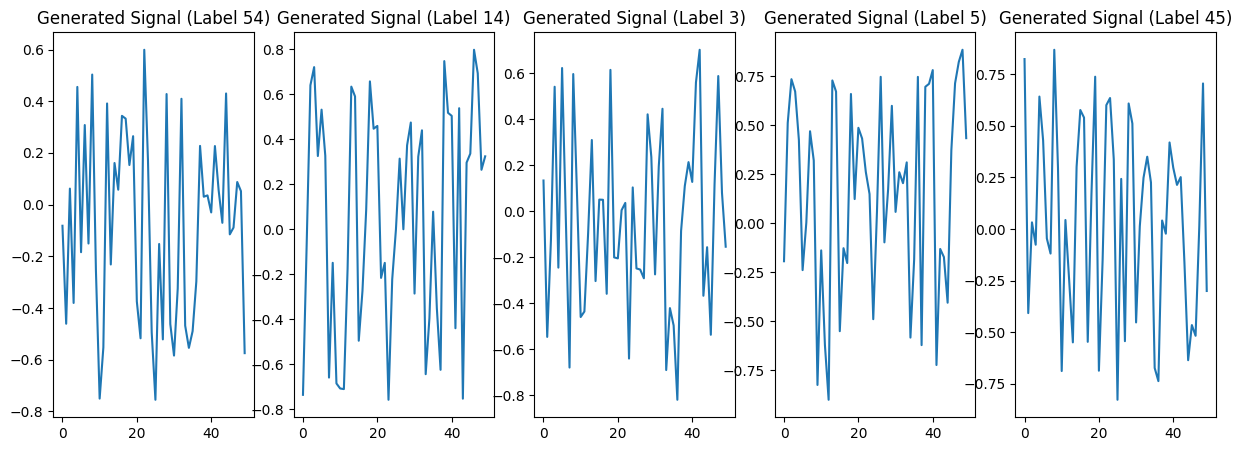

Epoch 601/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - d_loss: 0.2406 - feature_matching_loss: 122.4230 - g_loss: 125.0927
Epoch 602/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - d_loss: 0.2773 - feature_matching_loss: 110.5010 - g_loss: 113.5310
Epoch 603/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - d_loss: 0.2603 - feature_matching_loss: 109.5289 - g_loss: 112.2135
Epoch 604/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.2173 - feature_matching_loss: 113.4039 - g_loss: 115.9513
Epoch 605/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.2408 - feature_matching_loss: 105.0160 - g_loss: 107.5844
Epoch 606/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.2288 - feature_matching_loss: 114.6100 - g_loss: 117.2255
Epoch 607/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.2363 - feature_matching_loss: 115.5972 - g_loss: 118.2557
Epoch 608/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.2611 - feature_matching_loss: 113.0194 - g_loss: 115.6106


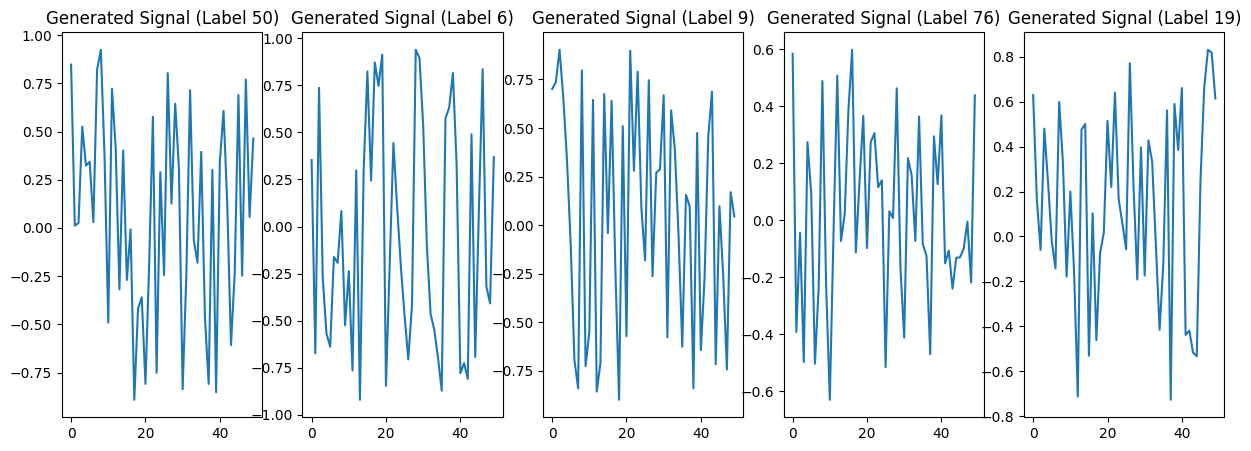

Epoch 651/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2356 - feature_matching_loss: 107.4156 - g_loss: 110.1534
Epoch 652/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - d_loss: 0.2230 - feature_matching_loss: 111.1786 - g_loss: 113.8008
Epoch 653/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - d_loss: 0.2363 - feature_matching_loss: 111.3374 - g_loss: 113.9214
Epoch 654/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - d_loss: 0.2777 - feature_matching_loss: 109.5605 - g_loss: 112.2729
Epoch 655/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2398 - feature_matching_loss: 109.0589 - g_loss: 111.6783
Epoch 656/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2467 - feature_matching_loss: 110.0355 - g_loss: 112.7054
Epoch 657/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - d_loss: 0.2288 - feature_matching_loss: 113.9941 - g_loss: 116.5124
Epoch 658/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.2235 - feature_matching_loss: 106.5523 - g_loss: 109.2536


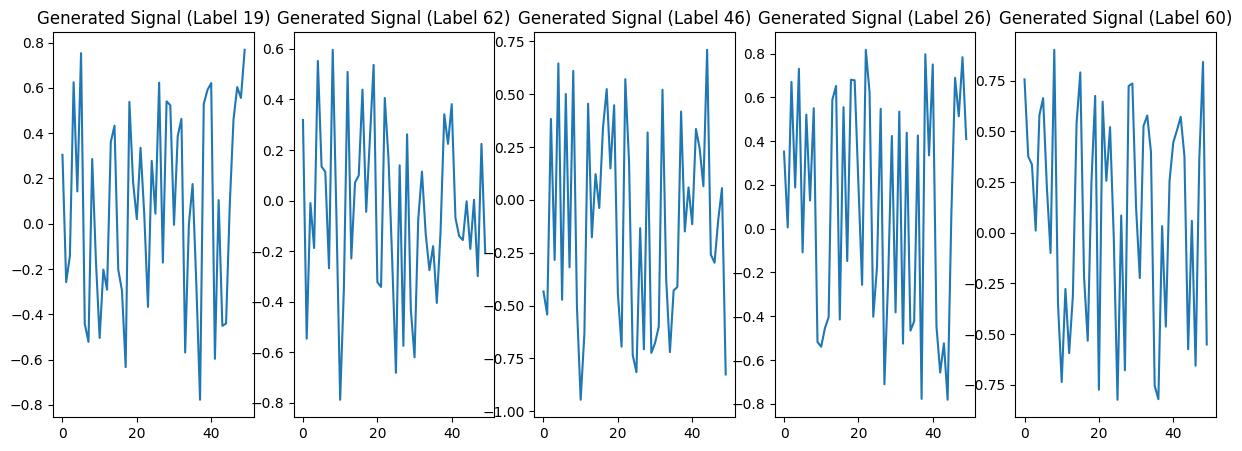

Epoch 701/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.2560 - feature_matching_loss: 101.0863 - g_loss: 103.5932
Epoch 702/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - d_loss: 0.2452 - feature_matching_loss: 103.7776 - g_loss: 106.2958
Epoch 703/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2474 - feature_matching_loss: 102.3239 - g_loss: 104.9125
Epoch 704/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2231 - feature_matching_loss: 101.9639 - g_loss: 104.5581
Epoch 705/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - d_loss: 0.2359 - feature_matching_loss: 95.6565 - g_loss: 98.2651
Epoch 706/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2272 - feature_matching_loss: 94.3755 - g_loss: 96.8740
Epoch 707/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2469 - feature_matching_loss: 93.7912 - g_loss: 96.3947
Epoch 708/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2243 - feature_matching_loss: 98.6175 - g_loss: 101.3169
Epoch 7

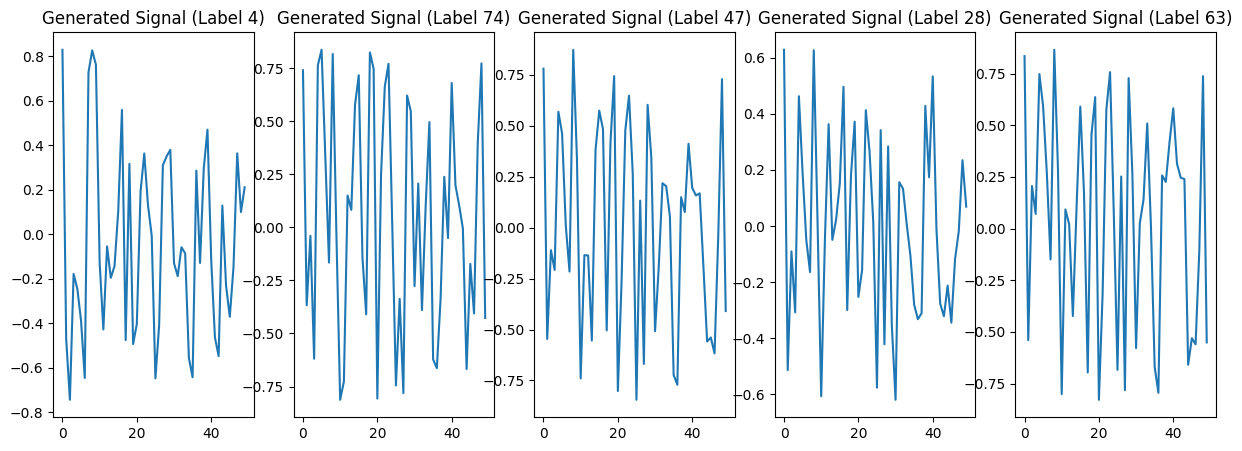

Epoch 751/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.2478 - feature_matching_loss: 103.9659 - g_loss: 106.5185
Epoch 752/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - d_loss: 0.2585 - feature_matching_loss: 106.3691 - g_loss: 109.0115
Epoch 753/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2591 - feature_matching_loss: 110.6307 - g_loss: 113.3020
Epoch 754/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2729 - feature_matching_loss: 103.9111 - g_loss: 106.5825
Epoch 755/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - d_loss: 0.2623 - feature_matching_loss: 105.3332 - g_loss: 107.9426
Epoch 756/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - d_loss: 0.2585 - feature_matching_loss: 109.2267 - g_loss: 111.9037
Epoch 757/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - d_loss: 0.2946 - feature_matching_loss: 107.2034 - g_loss: 110.1559
Epoch 758/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - d_loss: 0.2696 - feature_matching_loss: 103.2768 - g_loss: 105.7749


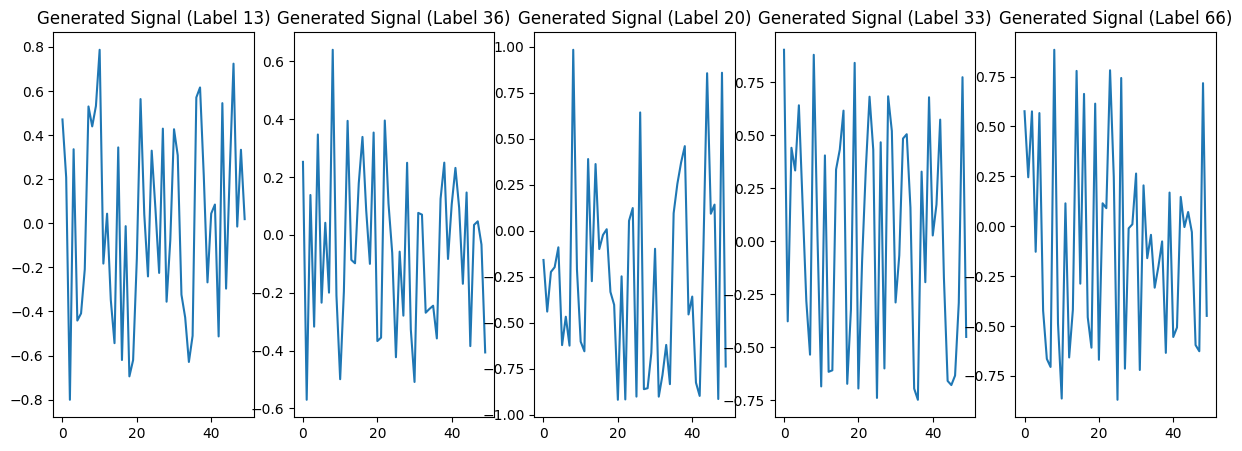

Epoch 801/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - d_loss: 0.2717 - feature_matching_loss: 109.0664 - g_loss: 111.5184
Epoch 802/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2791 - feature_matching_loss: 113.0292 - g_loss: 115.4741
Epoch 803/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2938 - feature_matching_loss: 103.3954 - g_loss: 105.9580
Epoch 804/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2652 - feature_matching_loss: 112.8699 - g_loss: 115.3461
Epoch 805/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2852 - feature_matching_loss: 112.3854 - g_loss: 114.8282
Epoch 806/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - d_loss: 0.2920 - feature_matching_loss: 107.8718 - g_loss: 110.4734
Epoch 807/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2824 - feature_matching_loss: 105.5933 - g_loss: 108.1750
Epoch 808/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2594 - feature_matching_loss: 117.2224 - g_loss: 119.7085


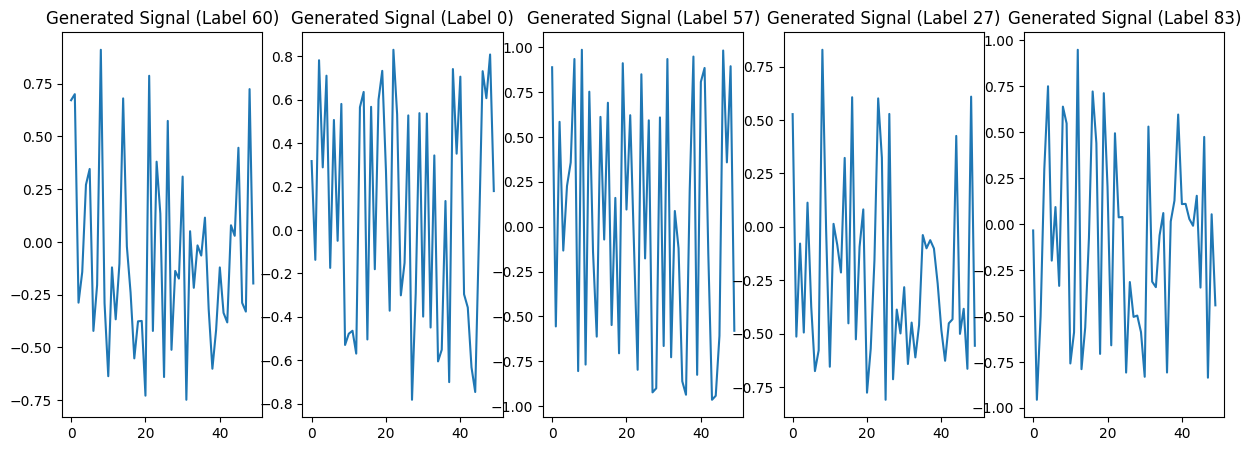

Epoch 851/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - d_loss: 0.2386 - feature_matching_loss: 110.0575 - g_loss: 112.6223
Epoch 852/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2555 - feature_matching_loss: 100.7918 - g_loss: 103.4356
Epoch 853/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - d_loss: 0.2464 - feature_matching_loss: 101.2824 - g_loss: 103.8791
Epoch 854/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2676 - feature_matching_loss: 88.8996 - g_loss: 91.4235
Epoch 855/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - d_loss: 0.2469 - feature_matching_loss: 90.5285 - g_loss: 93.1482
Epoch 856/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - d_loss: 0.2507 - feature_matching_loss: 99.5494 - g_loss: 102.1845
Epoch 857/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - d_loss: 0.2257 - feature_matching_loss: 94.7511 - g_loss: 97.4576
Epoch 858/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2387 - feature_matching_loss: 95.6344 - g_loss: 98.2581
Epoch 859

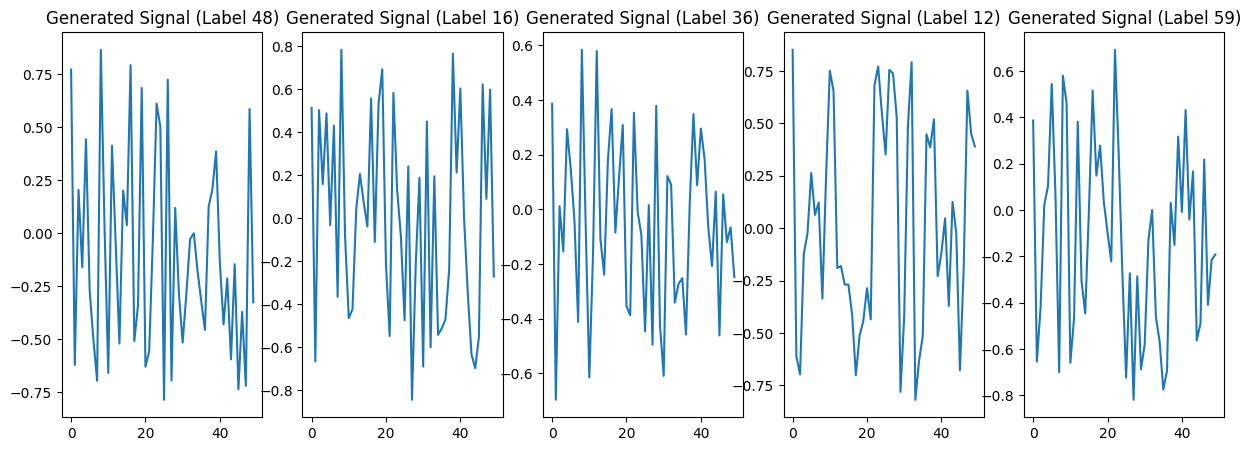

Epoch 901/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - d_loss: 0.2801 - feature_matching_loss: 89.2719 - g_loss: 91.7744
Epoch 902/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2811 - feature_matching_loss: 88.0685 - g_loss: 90.4574
Epoch 903/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2873 - feature_matching_loss: 87.8014 - g_loss: 90.3415
Epoch 904/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - d_loss: 0.2848 - feature_matching_loss: 87.2317 - g_loss: 89.7680
Epoch 905/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2551 - feature_matching_loss: 82.2658 - g_loss: 84.7346
Epoch 906/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2462 - feature_matching_loss: 98.9582 - g_loss: 101.5442
Epoch 907/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.3116 - feature_matching_loss: 99.9370 - g_loss: 102.6181 
Epoch 908/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2567 - feature_matching_loss: 92.5904 - g_loss: 95.2138
Epoch 909/100

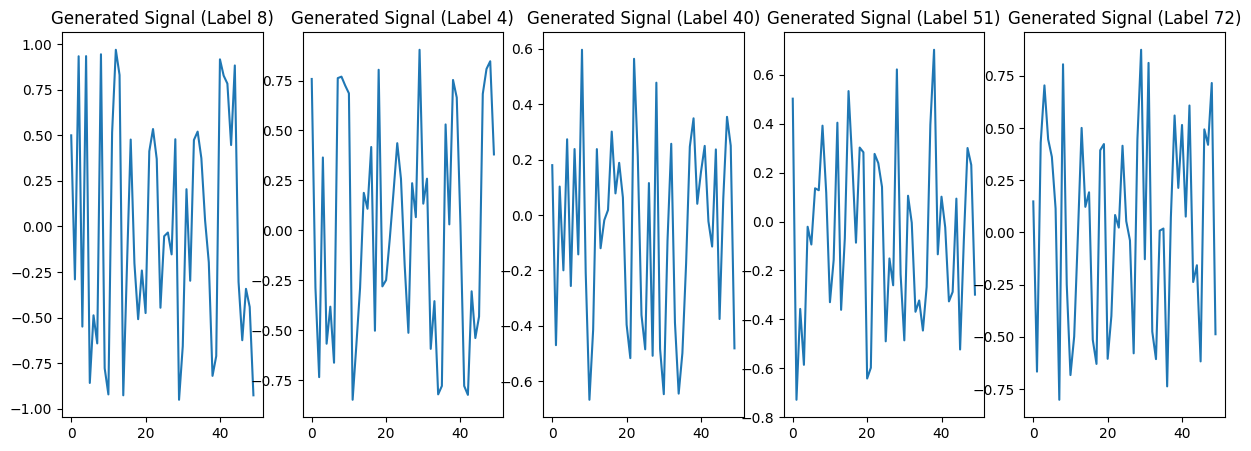

Epoch 951/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - d_loss: 0.2713 - feature_matching_loss: 119.6703 - g_loss: 121.9976
Epoch 952/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2613 - feature_matching_loss: 115.2865 - g_loss: 117.8629
Epoch 953/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - d_loss: 0.2659 - feature_matching_loss: 129.2343 - g_loss: 131.7940
Epoch 954/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - d_loss: 0.2508 - feature_matching_loss: 119.9698 - g_loss: 122.3902
Epoch 955/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - d_loss: 0.2595 - feature_matching_loss: 119.4792 - g_loss: 121.9998
Epoch 956/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - d_loss: 0.2941 - feature_matching_loss: 125.0008 - g_loss: 127.6010
Epoch 957/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - d_loss: 0.2791 - feature_matching_loss: 106.9468 - g_loss: 109.5070
Epoch 958/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - d_loss: 0.2881 - feature_matching_loss: 108.7345 - g_loss: 111.3365


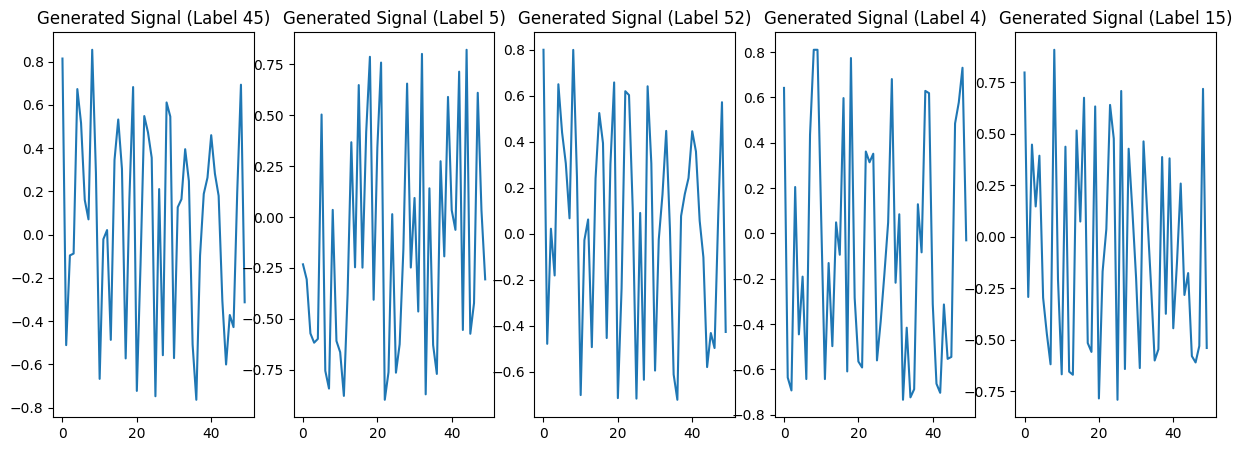

In [ ]:
# Prepare dataset: decomposed signals and one-hot encoded subject labels
decomposed_signals = np.array(concat_df['compressed_signals'].tolist())
subject_labels = pd.get_dummies(concat_df['Subject']).values  # One-hot encode subject labels

# Combine decomposed signals and subject labels in a TensorFlow Dataset
batch_size = 64
latent_dim = 128
num_subjects = subject_labels.shape[1]
signal_dim = decomposed_signals.shape[1]

dataset = tf.data.Dataset.from_tensor_slices((decomposed_signals, subject_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Label embedding size
label_embedding_size = 50

# Generator with label embedding
generator_input = keras.Input(shape=(latent_dim,))
label_input = keras.Input(shape=(num_subjects,))
label_embedding = keras.layers.Dense(label_embedding_size)(label_input)
x = keras.layers.Concatenate()([generator_input, label_embedding])
x = layers.Dense(128)(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Dense(256)(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
generator_output = layers.Dense(signal_dim, activation="tanh")(x)

generator = keras.Model([generator_input, label_input], generator_output, name="generator")

# Discriminator model with label embedding
discriminator_input = keras.Input(shape=(signal_dim,))
label_input_disc = keras.Input(shape=(num_subjects,))
label_embedding_disc = keras.layers.Dense(label_embedding_size)(label_input_disc)
x_disc = keras.layers.Concatenate()([discriminator_input, label_embedding_disc])
x_disc = layers.Dense(256)(x_disc)
x_disc = layers.LeakyReLU(negative_slope=0.2)(x_disc)
x_disc = layers.Dense(128)(x_disc)
x_disc = layers.LeakyReLU(negative_slope=0.2)(x_disc)
discriminator_output = layers.Dense(1)(x_disc)

discriminator = keras.Model([discriminator_input, label_input_disc], discriminator_output, name="discriminator")


class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.feature_matching_loss_tracker = keras.metrics.Mean(name="feature_matching_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.feature_matching_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_signals, one_hot_labels = data
        batch_size = tf.shape(real_signals)[0]

        # Generate random latent vectors and concatenate with labels
        random_latent_vectors = keras.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed_generator)
        generated_signals = self.generator([random_latent_vectors, one_hot_labels])

        # Combine real and fake signals for the discriminator
        fake_signal_and_labels = [generated_signals, one_hot_labels]
        real_signal_and_labels = [real_signals, one_hot_labels]
        combined_signals = [ops.concatenate([real_signals, generated_signals], axis=0),
                            ops.concatenate([one_hot_labels, one_hot_labels], axis=0)]

        # Labels for real (1) and fake (0) signals
        labels = ops.concatenate([ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_signals)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample new random latent vectors for generator training
        random_latent_vectors = keras.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed_generator)

        # Create labels for the generator: "all real"
        misleading_labels = ops.ones((batch_size, 1))

        # Train the generator (without updating the discriminator)
        with tf.GradientTape() as tape:
            fake_signals = self.generator([random_latent_vectors, one_hot_labels])
            fake_signal_and_labels = [fake_signals, one_hot_labels]
            predictions = self.discriminator(fake_signal_and_labels)

            # Feature matching loss (L2 distance between real and fake feature maps in the discriminator)
            real_features = self.discriminator(real_signal_and_labels, training=False)
            fake_features = self.discriminator(fake_signal_and_labels, training=False)
            feature_matching_loss = tf.reduce_mean(tf.square(real_features - fake_features))

            # Combine generator loss and feature matching loss
            g_loss = self.loss_fn(misleading_labels, predictions) + feature_matching_loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.feature_matching_loss_tracker.update_state(feature_matching_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "feature_matching_loss": self.feature_matching_loss_tracker.result(),
        }

# Visualization of generated signals
def plot_generated_signals(generator, epoch, num_samples=5):
    random_latent_vectors = keras.random.normal(shape=(num_samples, latent_dim))
    random_labels = np.eye(num_subjects)[np.random.choice(num_subjects, num_samples)]
    generated_signals = generator.predict([random_latent_vectors, random_labels])

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.plot(generated_signals[i])
        plt.title(f"Generated Signal (Label {np.argmax(random_labels[i])})")
    plt.show()

# Callbacks for early stopping and model checkpointing
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "gan_checkpoint.weights.h5", monitor="g_loss", save_best_only=True, save_weights_only=True
)

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="g_loss", patience=20, restore_best_weights=True, mode='min'
)

# Compile and train the model
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Custom training loop to include signal visualization
epochs = 1000
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    cond_gan.fit(dataset, epochs=1, callbacks=[checkpoint_callback, early_stopping_callback])

    # Every 50 epochs, visualize the generated signals
    if (epoch + 1) % 50 == 0:
        plot_generated_signals(generator, epoch)

In [ ]:
# # Prepare dataset: decomposed signals and one-hot encoded subject labels
# decomposed_signals = np.array(concat_df['dicomposed_singals'].tolist())
# subject_labels = pd.get_dummies(concat_df['Subject']).values  # One-hot encode subject labels

# # Combine decomposed signals and subject labels in a TensorFlow Dataset
# batch_size = 64
# latent_dim = 128
# num_subjects = subject_labels.shape[1]
# signal_dim = decomposed_signals.shape[1]

# dataset = tf.data.Dataset.from_tensor_slices((decomposed_signals, subject_labels))
# dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# # Label embedding size
# label_embedding_size = 50

# # Generator with label embedding
# generator = keras.Sequential([
#     keras.layers.InputLayer((latent_dim + num_subjects,)),
#     layers.Dense(128),
#     layers.LeakyReLU(negative_slope=0.2),
#     layers.Dense(256),
#     layers.LeakyReLU(negative_slope=0.2),
#     layers.Dense(signal_dim, activation="tanh"),
#     # layers.GaussianNoise(0.1)  # Add noise layer
# ])

# # Embedding and concatenation
# subject_embedding_layer = keras.layers.Embedding(num_subjects, label_embedding_size)

# # def generator_with_embedding(latent_vectors, subject_ids):
# #     subject_embeddings = subject_embedding_layer(subject_ids)
# #     latent_input = keras.layers.concatenate([latent_vectors, subject_embeddings])
# #     generated_signal = generator(latent_input)
# #     return generated_signal


# # Discriminator model
# discriminator = keras.Sequential(
#     [
#         keras.layers.InputLayer((signal_dim + num_subjects,)),
#         layers.Dense(256),
#         layers.LeakyReLU(negative_slope=0.2),
#         layers.Dense(128),
#         layers.LeakyReLU(negative_slope=0.2),
#         layers.Dense(1),  # Output real or fake decision
#     ],
#     name="discriminator",
# )


# class ConditionalGAN(keras.Model):
#     def __init__(self, discriminator, generator, latent_dim):
#         super().__init__()
#         self.discriminator = discriminator
#         self.generator = generator
#         self.latent_dim = latent_dim
#         self.seed_generator = keras.random.SeedGenerator(1337)
#         self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
#         self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
#         self.feature_matching_loss_tracker = keras.metrics.Mean(name="feature_matching_loss")

#     @property
#     def metrics(self):
#         return [self.gen_loss_tracker, self.disc_loss_tracker, self.feature_matching_loss_tracker]

#     def compile(self, d_optimizer, g_optimizer, loss_fn):
#         super().compile()
#         self.d_optimizer = d_optimizer
#         self.g_optimizer = g_optimizer
#         self.loss_fn = loss_fn

#     def train_step(self, data):
#         real_signals, one_hot_labels = data
#         batch_size = tf.shape(real_signals)[0]

#         # Generate random latent vectors and concatenate with labels
#         random_latent_vectors = keras.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed_generator)
#         random_vector_labels = ops.concatenate([random_latent_vectors, one_hot_labels], axis=1)

#         # Generate fake signals
#         generated_signals = self.generator(random_vector_labels)

#         # Combine real and fake signals for the discriminator
#         fake_signal_and_labels = ops.concatenate([generated_signals, one_hot_labels], axis=1)
#         real_signal_and_labels = ops.concatenate([real_signals, one_hot_labels], axis=1)
#         combined_signals = ops.concatenate([fake_signal_and_labels, real_signal_and_labels], axis=0)

#         # Labels for real (1) and fake (0) signals
#         labels = ops.concatenate([ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0)

#         # Train the discriminator
#         with tf.GradientTape() as tape:
#             predictions = self.discriminator(combined_signals)
#             d_loss = self.loss_fn(labels, predictions)
#         grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
#         self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

#         # Sample new random latent vectors for generator training
#         random_latent_vectors = keras.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed_generator)
#         random_vector_labels = ops.concatenate([random_latent_vectors, one_hot_labels], axis=1)

#         # Create labels for the generator: "all real"
#         misleading_labels = ops.ones((batch_size, 1))

#         # Train the generator (without updating the discriminator)
#         with tf.GradientTape() as tape:
#             fake_signals = self.generator(random_vector_labels)
#             fake_signal_and_labels = ops.concatenate([fake_signals, one_hot_labels], axis=1)
#             predictions = self.discriminator(fake_signal_and_labels)

#             # Feature matching loss (L2 distance between real and fake feature maps in the discriminator)
#             real_features = self.discriminator(real_signal_and_labels, training=False)
#             fake_features = self.discriminator(fake_signal_and_labels, training=False)
#             feature_matching_loss = tf.reduce_mean(tf.square(real_features - fake_features))

#             # Combine generator loss and feature matching loss
#             g_loss = self.loss_fn(misleading_labels, predictions) + feature_matching_loss
#         grads = tape.gradient(g_loss, self.generator.trainable_weights)
#         self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

#         # Monitor loss
#         self.gen_loss_tracker.update_state(g_loss)
#         self.disc_loss_tracker.update_state(d_loss)
#         self.feature_matching_loss_tracker.update_state(feature_matching_loss)

#         return {
#             "g_loss": self.gen_loss_tracker.result(),
#             "d_loss": self.disc_loss_tracker.result(),
#             "feature_matching_loss": self.feature_matching_loss_tracker.result(),
#         }

# cond_gan = ConditionalGAN(
#     discriminator=discriminator, generator=generator, latent_dim=latent_dim
# )
# cond_gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
# )

# # Train the model for 1000 epochs
# cond_gan.fit(dataset, epochs=1000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


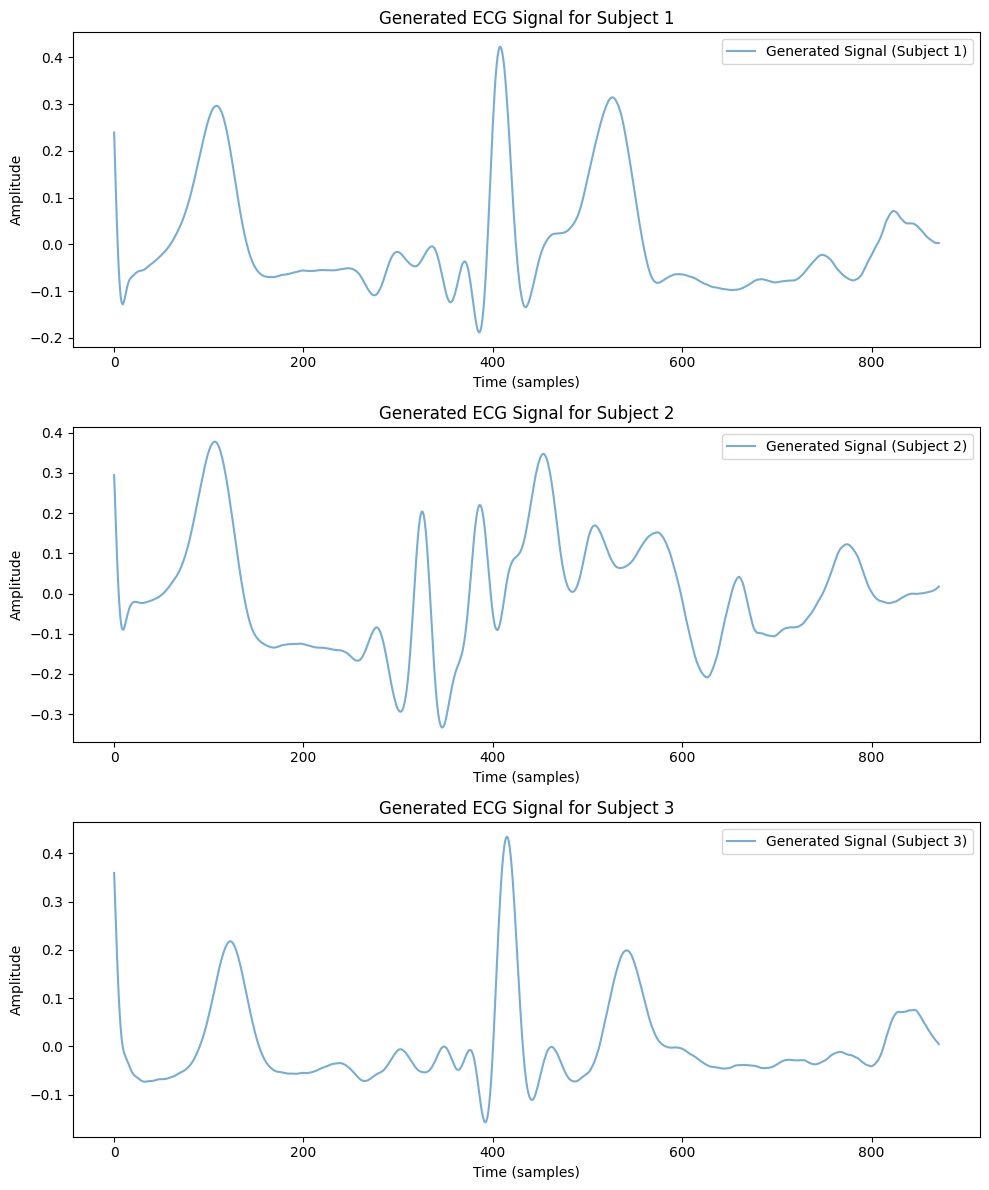

In [ ]:
def generate_ecg_for_subject(subject_id, num_signals=1):
    """
    Generate and reconstruct ECG signals for a given subject using the trained CGAN model.

    Parameters:
    - subject_id (int): The ID of the subject for which to generate signals.
    - num_signals (int): Number of signals to generate.

    Returns:
    - generated_ecg_signals (list of np.ndarray): List of generated ECG signals for the subject.
    """
    # Convert subject ID to one-hot encoding
    subject_one_hot = np.zeros((num_signals, num_subjects))
    subject_one_hot[:, subject_id - 1] = 1  # subject_id should be between 1 and num_subjects

    # Ensure both latent vectors and subject_one_hot are tensors
    subject_one_hot_tensor = tf.convert_to_tensor(subject_one_hot, dtype=tf.float32)

    # Generate random latent vectors as tensors
    random_latent_vectors = keras.random.normal(shape=(num_signals, latent_dim))

    # Generate decomposed signals using the generator (pass tensors directly)
    generated_decomposed_signals = generator([random_latent_vectors, subject_one_hot_tensor]).numpy()

    # Reconstruct the original ECG signals using PCA inverse transformation (decoder)
    generated_ecg_signals = decoder.predict(generated_decomposed_signals)

    return generated_ecg_signals


def plot_generated_signals_for_subjects(subject_ids, num_signals=1):
    """
    Generate and plot ECG signals for a list of Subject IDs.

    Parameters:
    - subject_ids (list of int): List of subject IDs to generate and compare signals for.
    - num_signals (int): Number of signals to generate per subject.
    """
    plt.figure(figsize=(10, len(subject_ids) * 4))

    for i, subject_id in enumerate(subject_ids):
        # Ensure subject_id is in range (1-based index)
        subject_id = max(1, subject_id)

        # Generate signals for the current subject
        generated_signals = generate_ecg_for_subject(subject_id, num_signals=num_signals)

        # Plot the generated signals
        plt.subplot(len(subject_ids), 1, i + 1)
        plt.plot(generated_signals[0], label=f'Generated Signal (Subject {subject_id})', alpha=0.6)

        # Add title and labels
        plt.title(f'Generated ECG Signal for Subject {subject_id}')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.show()


# Generate and compare signals for Subject IDs 1, 2, and 3
plot_generated_signals_for_subjects(subject_ids=[1, 2, 3], num_signals=1)

In [ ]:
# @title Default title text
# def find_stabilization_index(signal, window_size=20, delta_threshold=1e-3):
#     """
#     Find the index where the signal stabilizes (i.e., stops changing significantly).

#     Parameters:
#     - signal: np.ndarray, the input signal.
#     - window_size: int, the number of consecutive values to check for stability.
#     - delta_threshold: float, the threshold for the change between consecutive values to consider them "stable."

#     Returns:
#     - int, the index after which the signal can be rounded to zero.
#     """
#     # Compute the absolute differences between consecutive signal values
#     deltas = np.abs(np.diff(signal))

#     # Iterate over the signal in a windowed fashion to detect stabilization
#     for i in range(len(deltas) - window_size):
#         window_deltas = deltas[i:i + window_size]
#         # If all differences in the window are below the delta_threshold, we consider the signal stabilized
#         if np.all(window_deltas < delta_threshold):
#             return i + window_size  # Return the index where the stabilization starts

#     # If no stabilization is found, return the full length of the signal
#     return len(signal)

# def round_after_stabilization(signal, stabilization_idx):
#     """
#     Round all values after the stabilization index to zero.

#     Parameters:
#     - signal: np.ndarray, the input signal.
#     - stabilization_idx: int, the index after which values will be rounded to zero.

#     Returns:
#     - np.ndarray, the signal with values after the stabilization index set to zero.
#     """
#     signal[stabilization_idx:] = 0
#     return signal

# def denoise_signal(signal):
#   # Detect the stabilization index
#   stabilization_idx = find_stabilization_index(signal, window_size=15, delta_threshold=0.001)

#   # Round values after the stabilization index to zero
#   cleaned_signal = round_after_stabilization(signal.copy(), stabilization_idx)

#   return cleaned_signal

# def generate_ecg_for_subject(subject_id, num_signals=1):
#     """
#     Generate and reconstruct ECG signals for a given subject using the trained GAN model.

#     Parameters:
#     - subject_id (int): The ID of the subject for which to generate signals.
#     - num_signals (int): Number of signals to generate.

#     Returns:
#     - generated_ecg_signals (list of np.ndarray): List of generated ECG signals for the subject.
#     """
#     # Convert subject ID to one-hot encoding
#     subject_one_hot = np.zeros((num_signals, num_subjects))
#     subject_one_hot[:, subject_id - 1] = 1  # subject_id should be between 1 and num_subjects

#     # Generate random latent vectors
#     random_latent_vectors = keras.random.normal(shape=(num_signals, latent_dim))

#     # Concatenate latent vectors and one-hot encoded subject labels
#     latent_input = np.concatenate([random_latent_vectors, subject_one_hot], axis=1)

#     # Generate decomposed signals using the generator
#     generated_decomposed_signals = generator(latent_input).numpy()

#     # Reconstruct the original ECG signals using PCA inverse transformation
#     generated_ecg_signals = decoder.predict(generated_decomposed_signals)

#     # Apply thresholding to remove noise near zero
#     # cleaned_signal = threshold_near_zero(generated_ecg_signals, threshold=1e-1)

#     return generated_ecg_signals

# def plot_generated_signals_for_subjects(subject_ids, num_signals=1):
#     """
#     Generate and plot ECG signals for a list of Subject IDs.

#     Parameters:
#     - subject_ids (list of int): List of subject IDs to generate and compare signals for.
#     - num_signals (int): Number of signals to generate per subject.
#     """
#     plt.figure(figsize=(10, len(subject_ids) * 4))

#     for i, subject_id in enumerate(subject_ids):
#         # Ensure subject_id is in range (1-based index)
#         subject_id = max(1, subject_id)

#         # Generate signals for the current subject
#         generated_signals = generate_ecg_for_subject(subject_id, num_signals=num_signals)

#         # Get the denoised signal
#         # denoised_signal = denoise_signal(generated_signals[0])

#         # Plot the original and denoised signals for comparison
#         plt.subplot(len(subject_ids), 1, i + 1)
#         plt.plot(generated_signals[0], label=f'Original Signal (Subject {subject_id})', alpha=0.6)
#         # plt.plot(denoised_signal, label=f'Denoised Signal (Subject {subject_id})', linestyle='--')

#         # Add title and labels
#         plt.title(f'Generated ECG Signal for Subject {subject_id}')
#         plt.xlabel('Time (samples)')
#         plt.ylabel('Amplitude')
#         plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Generate and compare signals for Subject IDs 1, 2, and 3
# plot_generated_signals_for_subjects(subject_ids=[1, 2, 3], num_signals=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


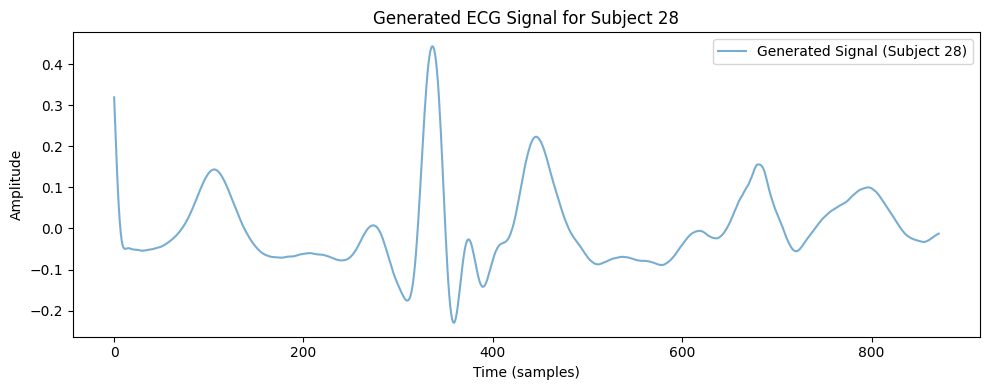

In [ ]:
plot_generated_signals_for_subjects(subject_ids=[28], num_signals=1)

In [ ]:
# @title Default title text
# # Ensure TensorFlow operations are done in eager execution
# tf.config.run_functions_eagerly(True)

# def generate_ecg_for_subject(subject_id, num_signals=1):
#     """
#     Generate and reconstruct ECG signals for a given subject using the trained CGAN model.

#     Parameters:
#     - subject_id (int): The ID of the subject for which to generate signals.
#     - num_signals (int): Number of signals to generate.

#     Returns:
#     - generated_ecg_signals (np.ndarray): Array of generated ECG signals for the subject.
#     """
#     # Convert subject ID to one-hot encoding
#     subject_one_hot = np.zeros((num_signals, num_subjects))
#     subject_one_hot[:, subject_id - 1] = 1  # subject_id should be between 1 and num_subjects

#     # Convert to TensorFlow tensors
#     subject_one_hot_tensor = tf.convert_to_tensor(subject_one_hot, dtype=tf.float32)
#     random_latent_vectors = tf.random.normal(shape=(num_signals, latent_dim))

#     # Generate decomposed signals using the generator
#     generated_decomposed_signals = generator([random_latent_vectors, subject_one_hot_tensor])

#     # Reconstruct the original ECG signals using PCA inverse transformation (decoder)
#     generated_ecg_signals = decoder.predict(generated_decomposed_signals)

#     return generated_ecg_signals

# def generate_signals_for_all_records(df, num_signals=1):
#     """
#     Generate synthetic signals for each record in the DataFrame and store them in a new column 'generated_signals'.

#     Parameters:
#     - df: The original DataFrame (concat_df) containing the decomposed signals.
#     - num_signals: The number of signals to generate per record (default is 1).

#     Returns:
#     - df: Updated DataFrame with a new column 'generated_signals'.
#     """
#     # Initialize an empty list to store generated signals
#     generated_signals_list = []

#     # Convert DataFrame columns to NumPy arrays for batch processing
#     subject_ids = df['Subject'].values
#     num_records = len(subject_ids)

#     # Process records in batches
#     batch_size = 64  # Adjust batch size based on memory capacity

#     for i in range(0, num_records, batch_size):
#         batch_subject_ids = subject_ids[i:i + batch_size]
#         num_batch_records = len(batch_subject_ids)

#         # Generate signals for this batch of subject IDs
#         generated_signals_batch = []

#         for subject_id in batch_subject_ids:
#             # Generate signals using GAN for this subject
#             generated_signals = generate_ecg_for_subject(subject_id, num_signals=num_signals)
#             # Append all generated signals for this subject
#             generated_signals_batch.extend(generated_signals)

#         # Ensure generated_signals_batch is a NumPy array
#         generated_signals_batch_array = np.array(generated_signals_batch)

#         # Append the generated signals for this batch to the list
#         generated_signals_list.extend(generated_signals_batch_array)

#     # Convert list to NumPy array
#     generated_signals_array = np.array(generated_signals_list)

#     # Add the generated signals to the DataFrame
#     df['generated_signals'] = [generated_signals_array[i:i + num_signals] for i in range(0, len(generated_signals_array), num_signals)]

#     return df

# # Define shape of the generated signal based on your model output
# signal_dim = 6861  # Adjust this to the shape of your generated signals

# # Update the DataFrame with generated signals
# concat_df_update = generate_signals_for_all_records(concat_df, num_signals=1)

In [ ]:
def generate_signals_for_all_records(df, num_signals=1):
    """
    Generate synthetic signals for each record in the DataFrame and store them in a new column 'generated_signals'.

    Parameters:
    - df: The original DataFrame (concat_df) containing the decomposed signals.
    - num_signals: The number of signals to generate per record (default is 1).

    Returns:
    - df: Updated DataFrame with a new column 'generated_signals'.
    """
    generated_signals_list = []

    for i, row in df.iterrows():
        subject_id = row['Subject']  # Fetch the subject ID
        # Generate signals using GAN for this subject
        generated_signal = generate_ecg_for_subject(subject_id, num_signals=num_signals)[0]
        # Denoise or threshold if needed (already part of generate_ecg_for_subject if necessary)
        # generated_signal = denoise_signal(generated_signal)
        generated_signals_list.append(generated_signal)

    # Add the generated signals to the DataFrame
    df['generated_signals'] = generated_signals_list
    return df

# Update the concat_df DataFrame with generated signals
concat_df_update = generate_signals_for_all_records(concat_df, num_signals=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [126]:
# Suppose concat_df_update is your DataFrame with generated signals
# Create a DataFrame for generated signals
generated_signals_df = concat_df_update[['generated_signals']].copy()
generated_signals_df['label'] = 1  # Label for generated signals

# Create a DataFrame for original ECG signals
original_signals_df = concat_df_update[['Smoothed_ECG_Samples']].copy()
original_signals_df['label'] = 0  # Label for original signals

# Check lengths
print(f"Length of generated signals DataFrame: {len(generated_signals_df)}")
print(f"Length of original signals DataFrame: {len(original_signals_df)}")

# Ensure signals and labels have the same length
signals = generated_signals_df['generated_signals'].tolist() + original_signals_df['Smoothed_ECG_Samples'].tolist()
labels = np.concatenate([
    np.ones(len(generated_signals_df)),  # Labels for generated signals
    np.zeros(len(original_signals_df))   # Labels for original signals
])

print(f"Length of signals: {len(signals)}")
print(f"Length of labels: {len(labels)}")


def extract_features(signals):
    features = []
    for signal in signals:
        mean = np.mean(signal)
        variance = np.var(signal)
        # Add more features if needed
        features.append([mean, variance])
    return np.array(features)

# Extract features
X_features = extract_features(signals)

print(f"Shape of X_features: {X_features.shape}")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, labels, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test_scaled)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Length of generated signals DataFrame: 2832
Length of original signals DataFrame: 2832
Length of signals: 5664
Length of labels: 5664
Shape of X_features: (5664, 2)
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.62      0.73       542
         1.0       0.73      0.92      0.81       591

    accuracy                           0.78      1133
   macro avg       0.80      0.77      0.77      1133
weighted avg       0.80      0.78      0.77      1133

Confusion Matrix:
[[338 204]
 [ 48 543]]


In [127]:
# Identify indices of generated signals misclassified as real
misclassified_indices = np.where((y_pred == 1) & (y_test == 0))[0]

print(f"Number of generated signals misclassified as real: {len(misclassified_indices)}")

Number of generated signals misclassified as real: 204


In [136]:
misclassified_indices[:5]

array([ 3,  5, 11, 17, 19])

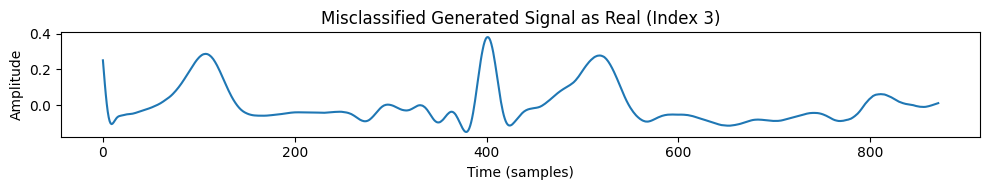

In [129]:
# Extract the misclassified signals from the test set
misclassified_signals = [signals[i] for i in misclassified_indices]

# Display some of the misclassified signals
num_to_show = min(1, len(misclassified_signals))  # Number of signals to display
plt.figure(figsize=(10, num_to_show * 2))

for i in range(num_to_show):
    plt.subplot(num_to_show, 1, i + 1)
    plt.plot(misclassified_signals[i])
    plt.title(f'Misclassified Generated Signal as Real (Index {misclassified_indices[i]})')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [130]:
# Get the signals classified as "real" by the SVM model
real_signals_idx = np.where(y_pred == 0)[0]  # Indices of signals classified as real

# Filter those signals from the combined list
real_signals = [signals[i] for i in real_signals_idx]

# If the original DataFrame contains subject IDs, we can also filter the corresponding IDs
real_subject_ids = concat_df_update['Subject'].tolist()
real_subject_ids = [real_subject_ids[i % len(concat_df_update)] for i in real_signals_idx]

In [131]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Dense, Flatten, Dropout

def build_light_lstm_cnn(input_shape, num_subjects):
    inputs = Input(shape=input_shape)

    # LSTM layer
    lstm_out = LSTM(32, return_sequences=True)(inputs)

    # CNN layers
    cnn_out = Conv1D(32, kernel_size=3, activation='relu')(lstm_out)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)

    # Flatten for dense layers
    flat_out = Flatten()(cnn_out)

    # Dense layers
    dense_out = Dense(64, activation='relu')(flat_out)
    dense_out = Dropout(0.3)(dense_out)

    # Output layer for multi-class classification (subject IDs)
    outputs = Dense(num_subjects, activation='softmax')(dense_out)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Assuming input_shape based on length of signals and number of subjects
input_shape = (len(real_signals[0]), 1)  # Example for 1D ECG signals
num_subjects = len(concat_df_update['Subject'].unique())  # Number of unique subjects

# Build the model
subject_classification_model = build_light_lstm_cnn(input_shape, num_subjects)
subject_classification_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 872, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 872, 32)             │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 870, 32)             │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 435, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 13920)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │         890,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 84)                  │           5,460 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 903,860 (3.45 MB)

 Trainable params: 903,860 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

In [132]:
# Reshape the signals to 3D for LSTM-CNN model (samples, timesteps, features)
real_signals_array = np.array(real_signals)
real_signals_array = real_signals_array.reshape((real_signals_array.shape[0], real_signals_array.shape[1], 1))

# Convert subject IDs to a numeric format
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
real_subject_ids_encoded = label_encoder.fit_transform(real_subject_ids)

In [133]:
from sklearn.model_selection import train_test_split

# Split the real signals into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(real_signals_array, real_subject_ids_encoded, test_size=0.2, random_state=42)

# Train the LSTM-CNN model
subject_classification_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = subject_classification_model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 485ms/step - accuracy: 0.2495 - loss: 4.1575 - val_accuracy: 0.5000 - val_loss: 2.5118
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.4731 - loss: 2.6280 - val_accuracy: 0.5769 - val_loss: 1.5117
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 439ms/step - accuracy: 0.5398 - loss: 1.7457 - val_accuracy: 0.7308 - val_loss: 0.9654
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.6054 - loss: 1.3388 - val_accuracy: 0.7821 - val_loss: 0.7004
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.7280 - loss: 0.8761 - val_accuracy: 0.8846 - val_loss: 0.4358
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 463ms/step - accuracy: 0.7780 - loss: 0.7529 - val_accuracy: 0.8846 - val_loss: 0.3088
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - accuracy: 0.8310 - loss: 0.5237 - val_accuracy: 0.9359 - val_loss: 0.2351
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.8567 - loss: 0.3879 - val_accuracy: 0.

In [134]:
# Get predicted probabilities for each instance in X_test
y_pred_probs = subject_classification_model.predict(X_test)

# Get the index of the highest probability for each sample, which corresponds to the predicted class (subject ID)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert the predicted class indices back to the original subject IDs using the label encoder
y_pred_subject_ids = label_encoder.inverse_transform(y_pred_classes)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


In [135]:
# Print a few predictions along with their corresponding true subject IDs
for i in range(10):  # Display the first 10 predictions
    print(f"Predicted Subject ID: {y_pred_subject_ids[i]}, True Subject ID: {label_encoder.inverse_transform([y_test[i]])[0]}")

Predicted Subject ID: 25, True Subject ID: 25
Predicted Subject ID: 22, True Subject ID: 22
Predicted Subject ID: 2, True Subject ID: 2
Predicted Subject ID: 16, True Subject ID: 16
Predicted Subject ID: 3, True Subject ID: 3
Predicted Subject ID: 21, True Subject ID: 21
Predicted Subject ID: 2, True Subject ID: 2
Predicted Subject ID: 2, True Subject ID: 2
Predicted Subject ID: 23, True Subject ID: 23
Predicted Subject ID: 1, True Subject ID: 1
